# 1. Environment Setup


In [1]:
import json
import torch
import numpy as np
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from pathlib import Path
from types import SimpleNamespace
from importlib import import_module
import random

%matplotlib inline

In [2]:
from senn.models.losses import *
from senn.models.parameterizers import *
from senn.models.conceptizers import *
from senn.models.aggregators import *
from senn.models.senn import SENN, DiSENN

In [3]:
from senn.datasets.dataloaders import get_dataloader
from senn.utils.plot_utils import show_explainations, show_prototypes, plot_lambda_accuracy, get_comparison_plot

In [4]:
from rotation import rotate_resize_and_cast, rotate_image

## Utility functions

In [5]:
def get_config(filename):
    config_path = Path('configs')
    config_file = config_path / filename
    with open(config_file, 'r') as f:
        config = json.load(f)
    
    return SimpleNamespace(**config)

In [6]:
def load_checkpoint(config):
    model_file = Path('results') / config.exp_name / "checkpoints" / "best_model.pt" 
    return torch.load(model_file, config.device)

In [7]:
def accuracy(model, dataloader, config):
    accuracies = []
    model.eval()
    with torch.no_grad():
        for i, (x, labels) in enumerate(dataloader):
            x = x.float().to(config.device)
            labels = labels.long().to(config.device)
            y_pred, (concepts, relevances), _ = model(x)
            accuracies.append((y_pred.argmax(axis=1) == labels).float().mean().item())
    accuracy = np.array(accuracies).mean()
    print(f"Test Mean Accuracy: {accuracy * 100: .3f} %")

## Config

In [8]:
plt.style.use('seaborn-v0_8-paper')

# 2. Basic Comparisons

In [9]:
mnist_config = get_config("mnist_lambda1e-4_seed29.json")
mnist_config.device = "cpu"

In [10]:
_, _, mnist_test_dl = get_dataloader(mnist_config)

In [11]:
conceptizer = ConvConceptizer(**mnist_config.__dict__)
parameterizer = ConvParameterizer(**mnist_config.__dict__)
aggregator = SumAggregator(**mnist_config.__dict__)

mnist_SENN = SENN(conceptizer, parameterizer, aggregator)

In [12]:
mnist_checkpoint = load_checkpoint(mnist_config)
mnist_SENN.load_state_dict(mnist_checkpoint['model_state'])

/var/folders/7s/51n924ds2p15l54wx1p9dwm80000gn/T/ipykernel_19817/3168636641.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(model_file, config.device)


<All keys matched successfully>

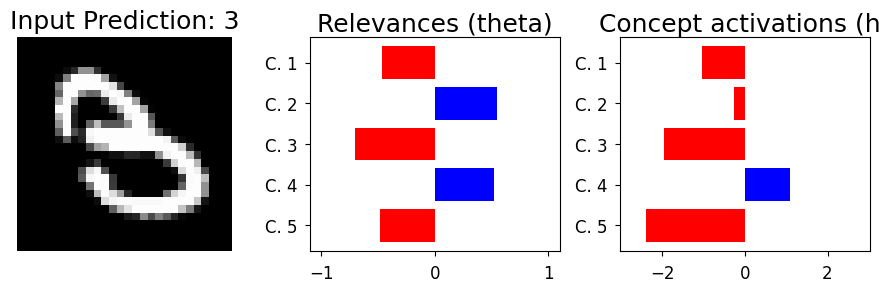

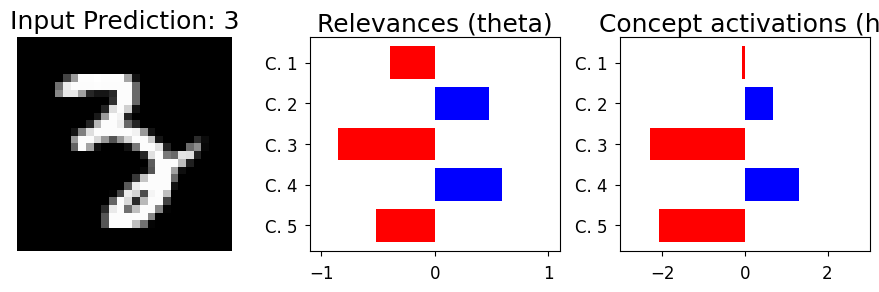

In [13]:
show_explainations(mnist_SENN, mnist_test_dl, 'mnist')

In [14]:
# Imports
import json
from os import path
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import cv2

from rotation import rotate_resize_and_cast

from senn.utils.plot_utils import (
    create_barplot,
    plot_lambda_accuracy,
    show_explainations
)

plt.style.use('seaborn-v0_8-paper')

def show_explanation_with_rotation(model, image, x_rotation=0, y_rotation=0, z_rotation=0, save_path=None):
    """Shows SENN explanations for original and rotated versions of an image."""
    device = 'cuda:0' if next(model.parameters()).is_cuda else 'cpu'
    model.eval()

    original_img = image
    
    image_np = image.squeeze().cpu().numpy()
    
    image_bgr = cv2.merge([image_np] * 3)
    
    _, rotated_canvas = rotate_resize_and_cast(
        image_bgr, 
        x_rotation=x_rotation,
        y_rotation=y_rotation,
        z_rotation=z_rotation
    )
    rotated_tensor = torch.tensor(rotated_canvas[:,:,0]).unsqueeze(0).float().to(device)
    
    # Get SENN explanations for both
    with torch.no_grad():
        y_pred_orig, (concepts_orig, relevances_orig), _ = model(original_img)
        y_pred_rot, (concepts_rot, relevances_rot), _ = model(rotated_tensor)
    
    if len(y_pred_orig.size()) > 1:
        y_pred_orig = y_pred_orig.argmax(1)
        y_pred_rot = y_pred_rot.argmax(1)
    
    # Get concept limits for consistent plotting
    concepts = torch.cat([concepts_orig, concepts_rot])
    concepts_min = concepts.min().item()
    concepts_max = concepts.max().item()
    concept_lim = max(abs(concepts_min), abs(concepts_max))
    
    # Create figure
    fig = plt.figure(figsize=(15, 6))
    gridsize = (2, 3)
    
    # Original image and its explanations
    ax1 = plt.subplot2grid(gridsize, (0, 0))
    ax2 = plt.subplot2grid(gridsize, (0, 1))
    ax3 = plt.subplot2grid(gridsize, (0, 2))
    
    # Rotated image and its explanations
    ax4 = plt.subplot2grid(gridsize, (1, 0))
    ax5 = plt.subplot2grid(gridsize, (1, 1))
    ax6 = plt.subplot2grid(gridsize, (1, 2))
    
    # Plot original image and explanations
    ax1.imshow(original_img.squeeze().cpu(), cmap='gray')
    ax1.set_axis_off()
    ax1.set_title(f'Original - Pred: {y_pred_orig.item()}', fontsize=12)
    
    create_barplot(ax2, relevances_orig[0], y_pred_orig[0], x_label='Relevances (θ)')
    ax2.xaxis.set_label_position('top')
    ax2.tick_params(which='major', labelsize=10)
    
    create_barplot(ax3, concepts_orig[0], y_pred_orig[0], 
                  x_lim=concept_lim, x_label='Concepts (h)')
    ax3.xaxis.set_label_position('top')
    ax3.tick_params(which='major', labelsize=10)
    
    # Plot rotated image and explanations
    ax4.imshow(rotated_canvas[:,:,0], cmap='gray')  # Display directly from the OpenCV output
    ax4.set_axis_off()
    ax4.set_title(f'Rotated ({x_rotation}°,{y_rotation}°,{z_rotation}°) - Pred: {y_pred_rot.item()}', fontsize=12)
    
    create_barplot(ax5, relevances_rot[0], y_pred_rot[0], x_label='Relevances (θ)')
    ax5.tick_params(which='major', labelsize=10)
    
    create_barplot(ax6, concepts_rot[0], y_pred_rot[0], 
                  x_lim=concept_lim, x_label='Concepts (h)')
    ax6.tick_params(which='major', labelsize=10)
    
    plt.tight_layout()
    plt.show()
    plt.close('all')


Minor Rotations
--------------------------------------------------

X-Axis Rotations

X-Rotation Example 1/5 (angle: -14°)


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


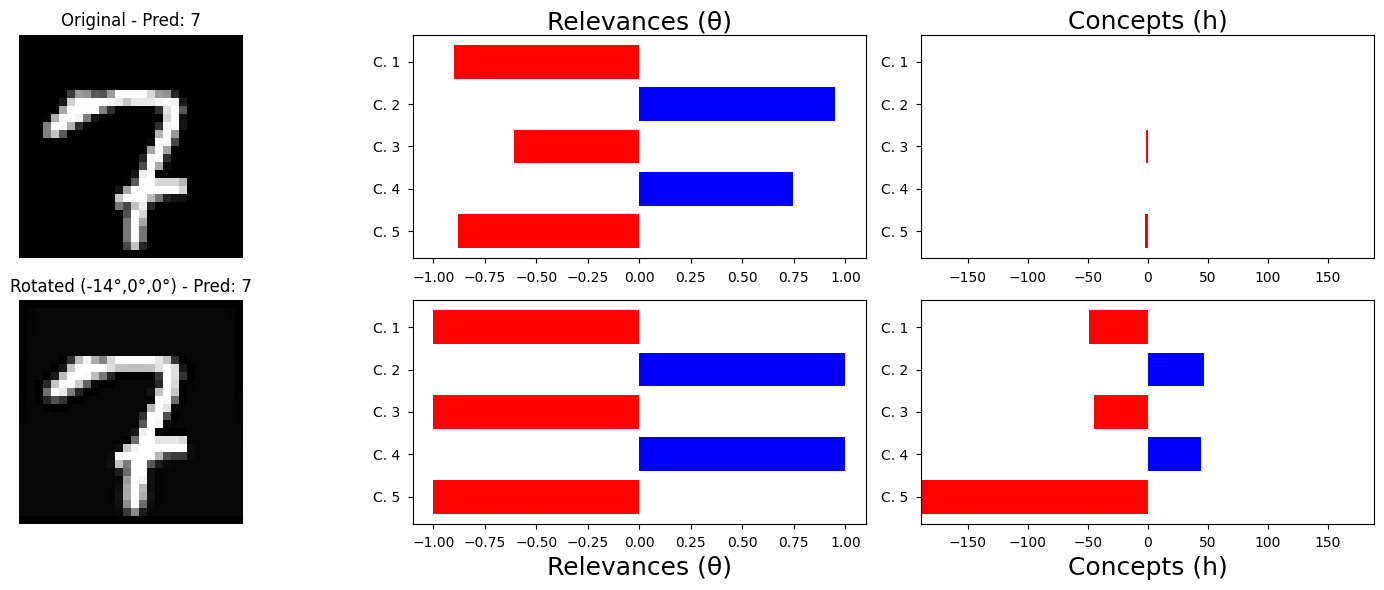


Y-Axis Rotations

Y-Rotation Example 1/5 (angle: 25°)


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


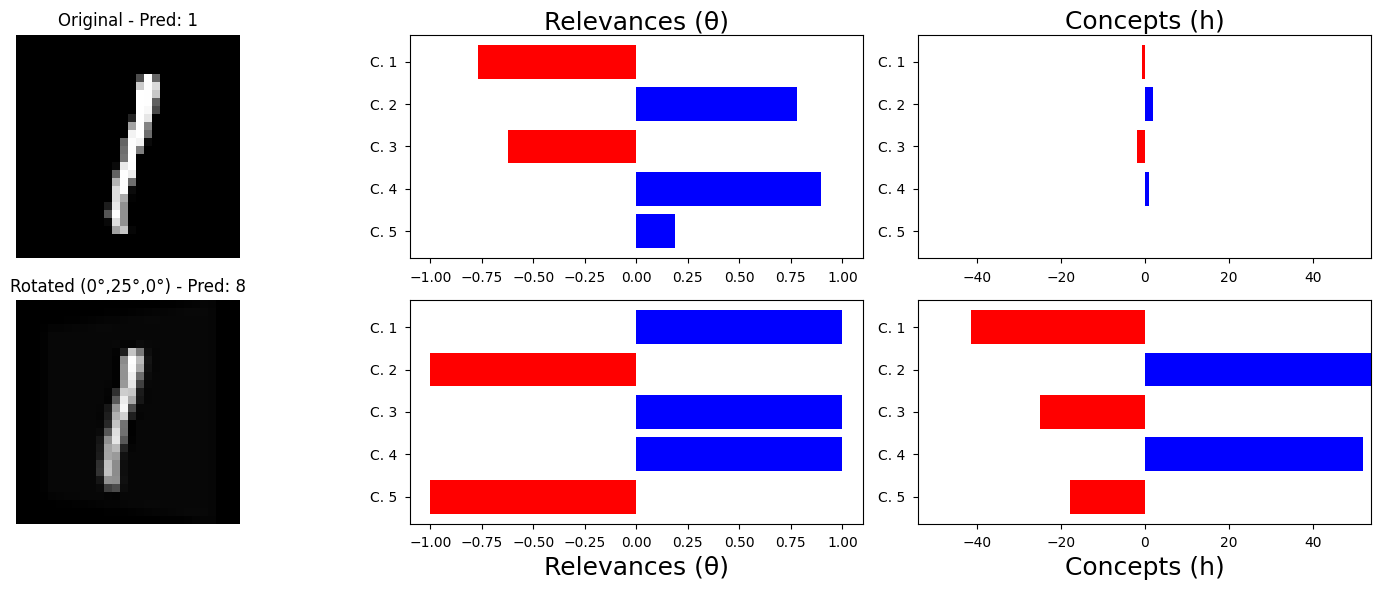


Z-Axis Rotations

Z-Rotation Example 1/5 (angle: 19°)


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


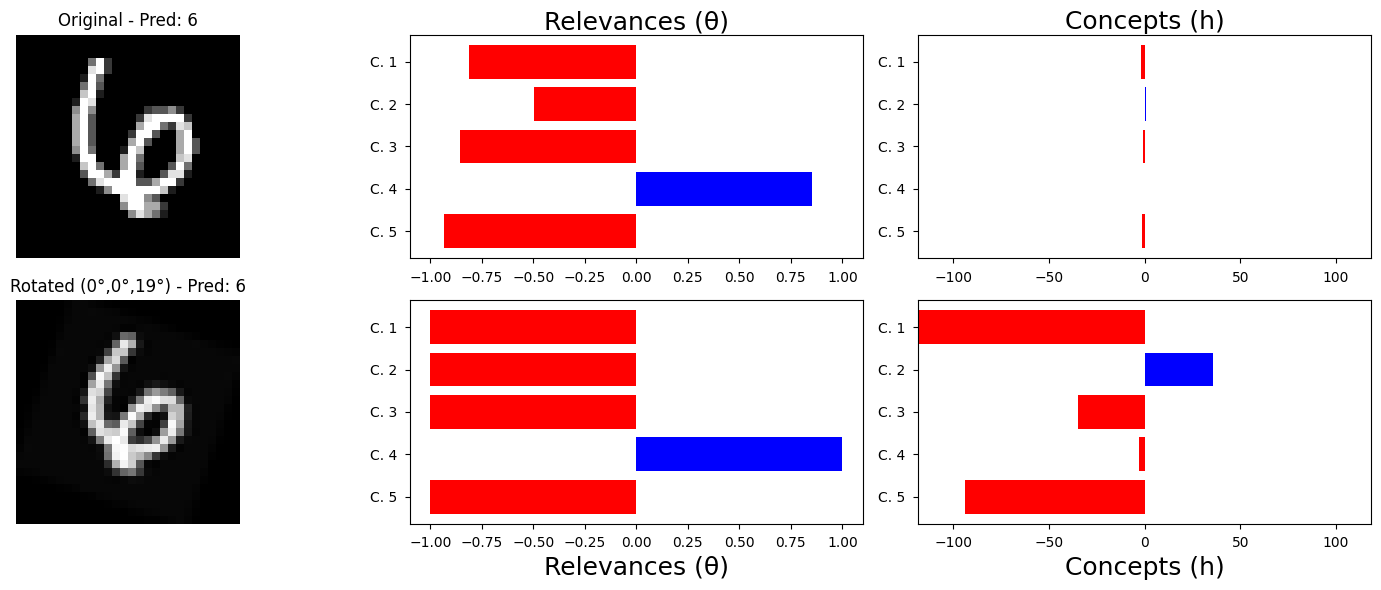


Moderate Rotations
--------------------------------------------------

X-Axis Rotations

X-Rotation Example 1/5 (angle: 31°)


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


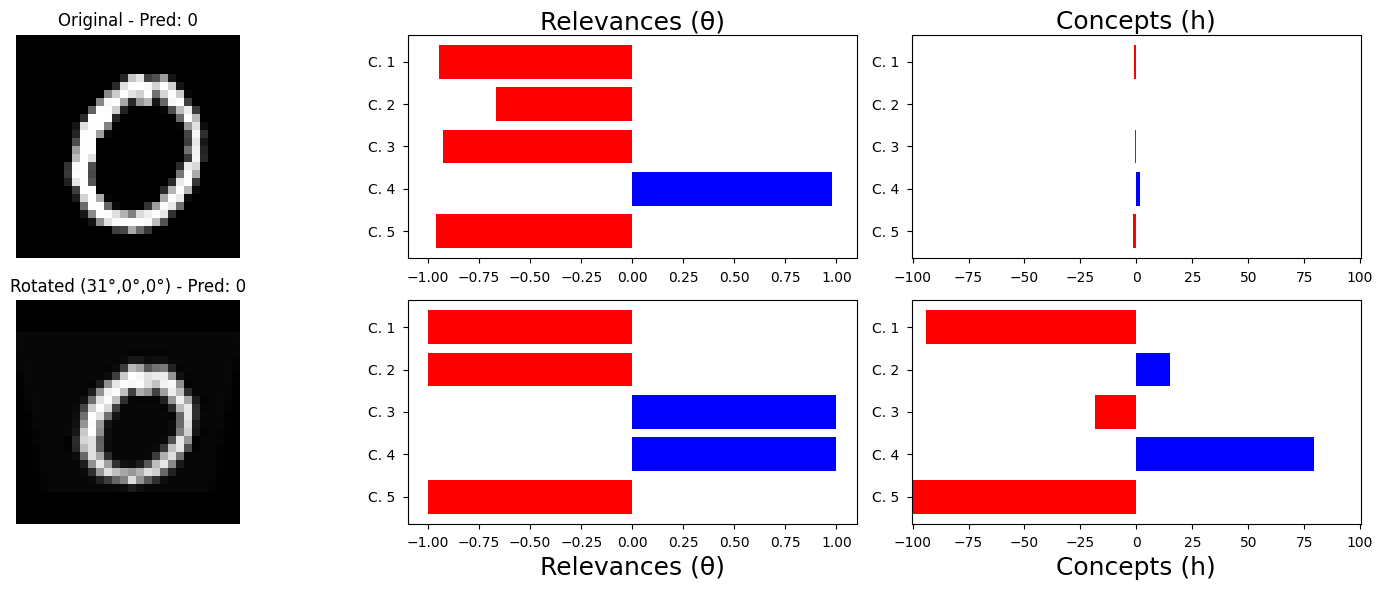


Y-Axis Rotations

Y-Rotation Example 1/5 (angle: -58°)


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


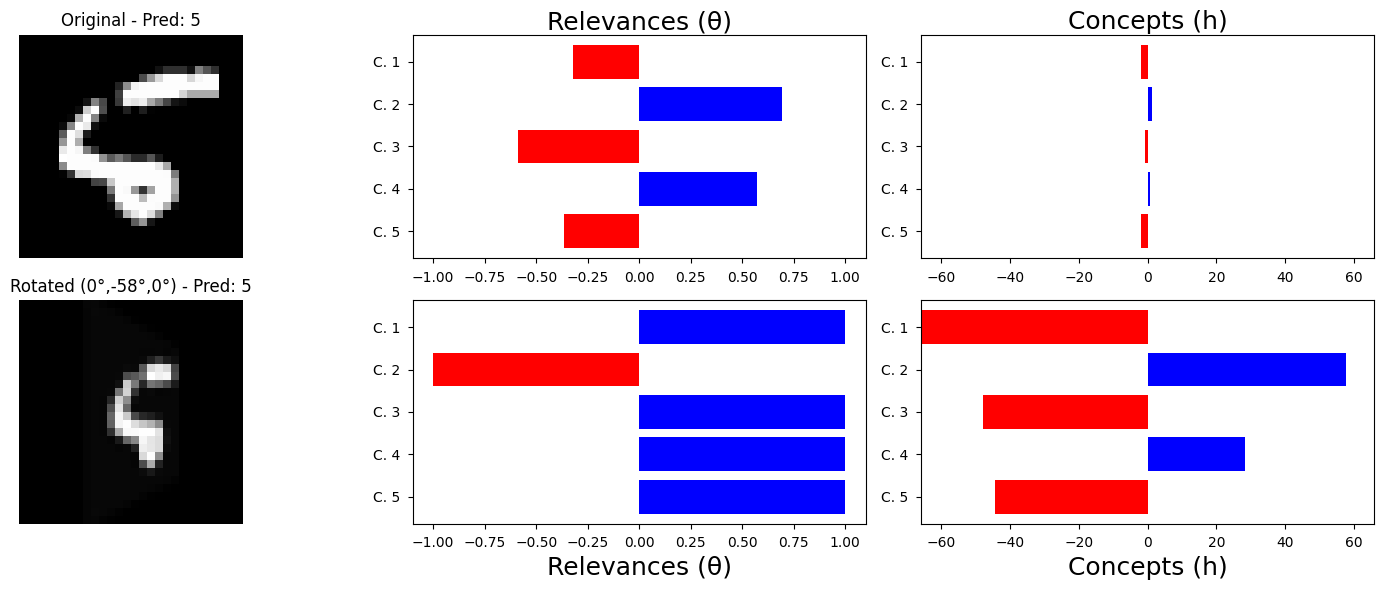


Z-Axis Rotations

Z-Rotation Example 1/5 (angle: -52°)


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


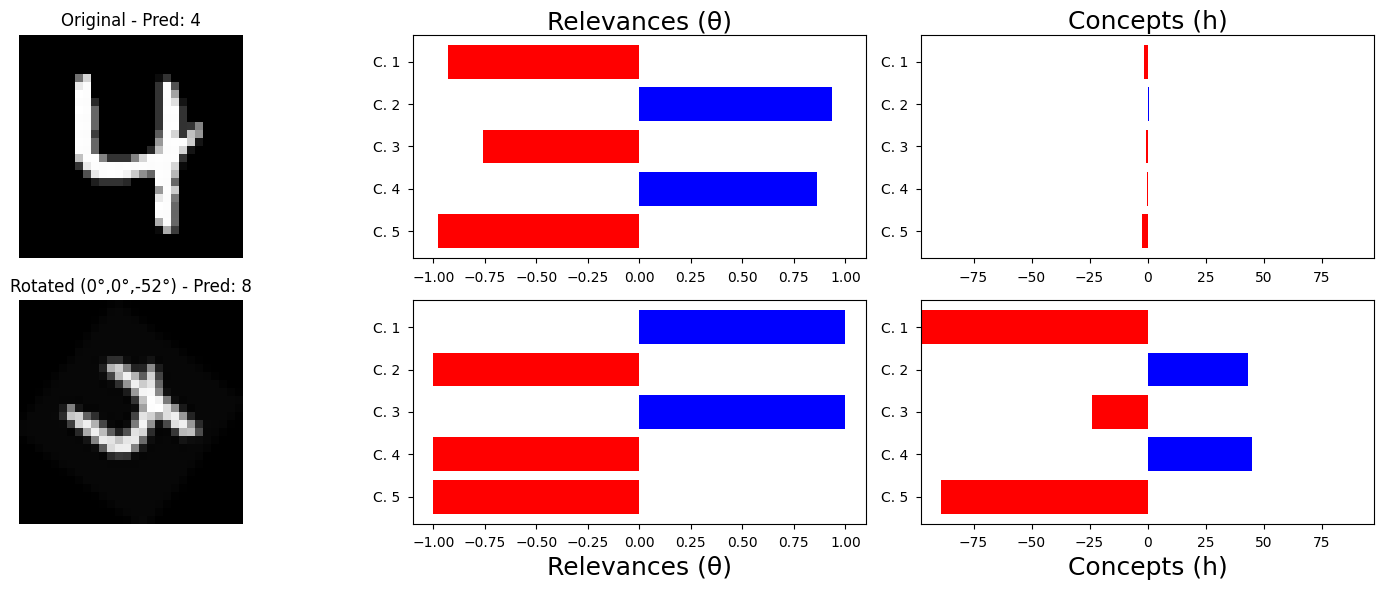


Extreme Rotations
--------------------------------------------------

X-Axis Rotations

X-Rotation Example 1/5 (angle: 62°)


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


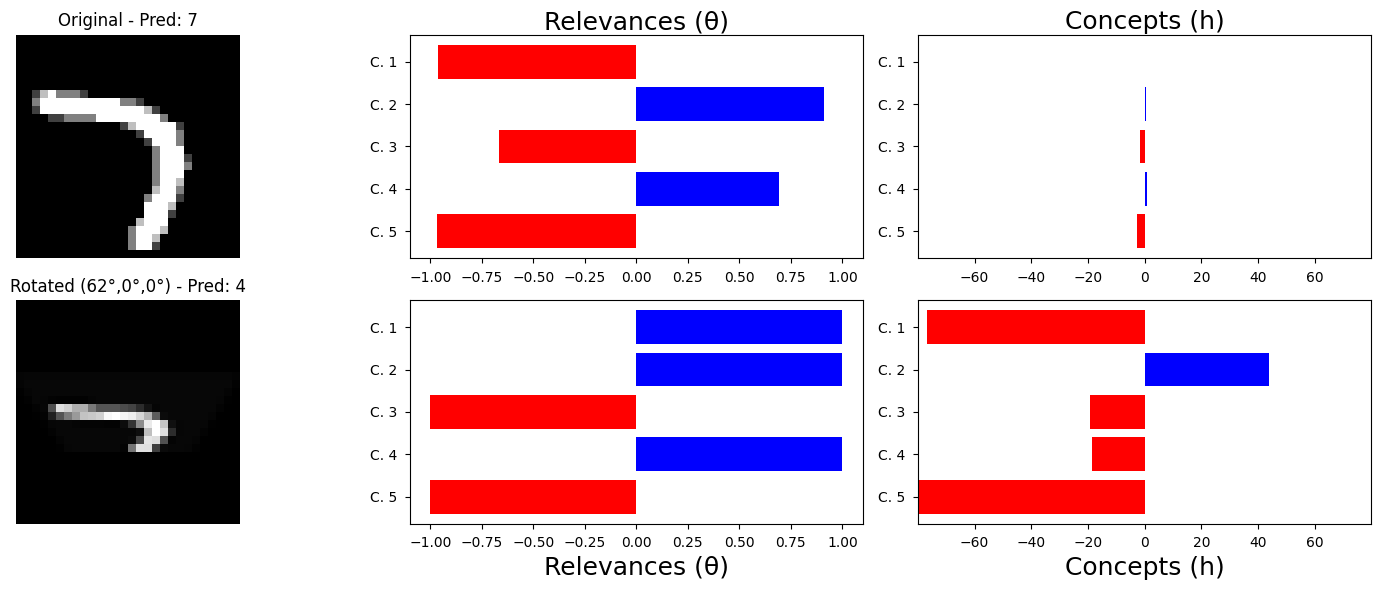


Y-Axis Rotations

Y-Rotation Example 1/5 (angle: -68°)


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


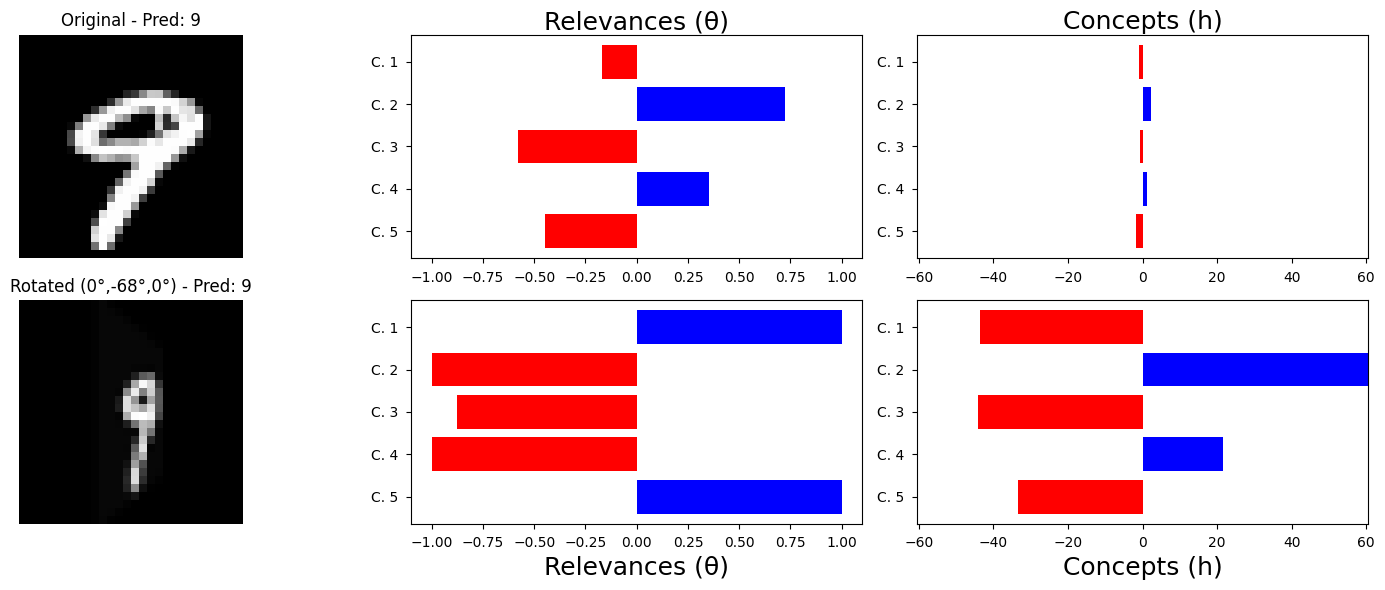


Z-Axis Rotations

Z-Rotation Example 1/5 (angle: 67°)


/Users/khoinguyen/Programming/SENN/venv/lib/python3.12/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


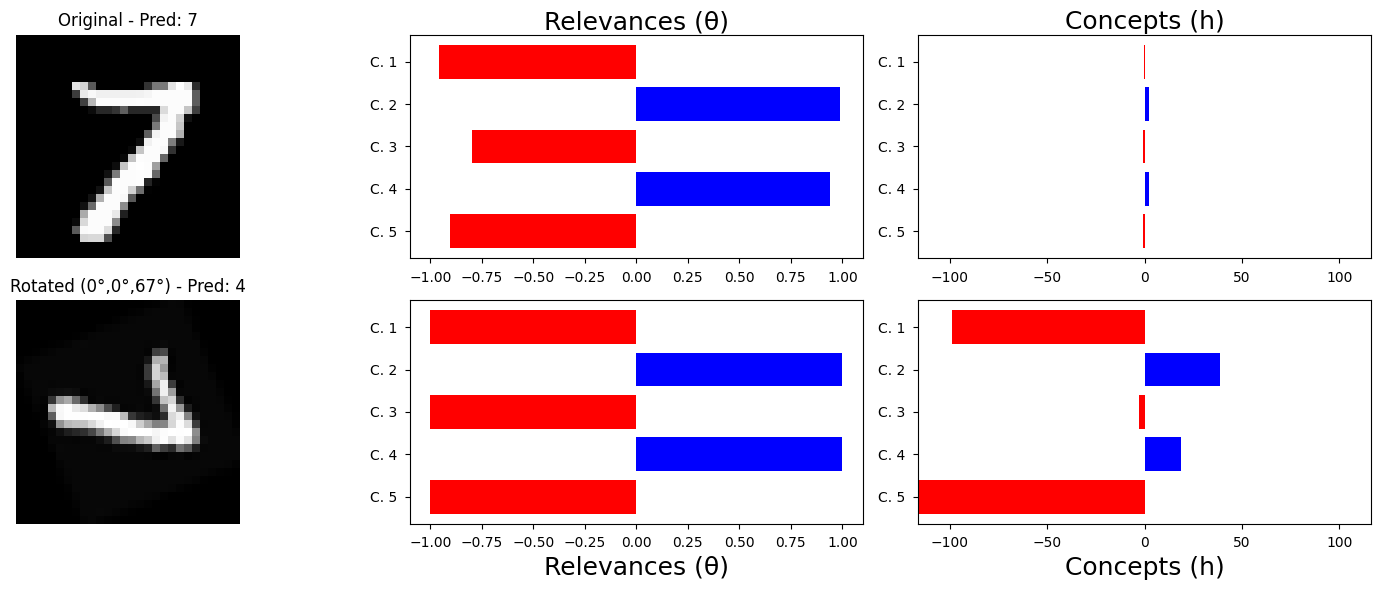

In [15]:
# Define rotation ranges
minor_range = (-30, 30)  # Single tuple for minor
moderate_ranges = [(-60, -31), (31, 60)]  # List of tuples for moderate
extreme_ranges = [(-85, -61), (61, 85)]  # List of tuples for moderate

def get_random_angle(angle_range):
    """Get random angle from either a single range tuple or list of range tuples"""
    if isinstance(angle_range[0], tuple):  # Multiple ranges (moderate/extreme)
        selected_range = random.choice(angle_range)
        return np.random.randint(selected_range[0], selected_range[1])
    else:  # Single range (minor)
        return np.random.randint(angle_range[0], angle_range[1])

# Example usage in your loop:
for severity, ranges in [
    ("Minor", minor_range),
    ("Moderate", moderate_ranges),
    ("Extreme", extreme_ranges)
]:
    print(f"\n{severity} Rotations")
    print("-" * 50)
    
    # For each axis (X, Y, Z)
    for axis in ["X", "Y", "Z"]:
        print(f"\n{axis}-Axis Rotations")
        for i in range(1):
            test_batch, _ = next(iter(mnist_test_dl))
            random_idx = np.random.randint(0, len(test_batch))
            sample_image = test_batch[random_idx]
            
            angle = get_random_angle(ranges)
            print(f"\n{axis}-Rotation Example {i+1}/5 (angle: {angle}°)")
            
            rotation_args = {
                f"{axis.lower()}_rotation": angle
            }
            show_explanation_with_rotation(
                model=mnist_SENN,
                image=sample_image,
                **rotation_args
            )

In [16]:
from IPython.display import Image, display, HTML
import imageio
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import torch

def show_increasing_perturbation(model, image, axis='x', save_path=None):
    """Shows SENN explanations for increasingly perturbed versions of an image."""
    angles = list(range(0, 82, 8))
    device = 'cuda:0' if next(model.parameters()).is_cuda else 'cpu'
    model.eval()
    
    # Fixed score ranges for visualization
    RELEVANCE_RANGE = (-1, 1)
    CONCEPT_RANGE = (-2, 2)
    
    def normalize_to_range(values, target_range):
        """Normalize values to target range while preserving zero"""
        if torch.all(values == 0):
            return values
        
        target_min, target_max = target_range
        pos_mask = values > 0
        neg_mask = values < 0
        
        normalized = torch.zeros_like(values)
        
        if torch.any(pos_mask):
            pos_values = values[pos_mask]
            normalized[pos_mask] = pos_values / torch.max(torch.abs(pos_values)) * target_max
            
        if torch.any(neg_mask):
            neg_values = values[neg_mask]
            normalized[neg_mask] = neg_values / torch.max(torch.abs(neg_values)) * abs(target_min)
            
        return normalized
    
    # Generate rotated versions
    rotated_tensors = []
    
    # Original and rotated images
    image_np = image.squeeze().cpu().numpy()
    image_bgr = cv2.merge([image_np] * 3)
    
    for angle in angles:
        if angle == 0:  # Original image
            rotated_tensors.append(image.unsqueeze(0) if len(image.shape) == 2 else image)
        else:  # Rotated versions
            rotation_args = {f"{axis.lower()}_rotation": angle}
            _, rotated_canvas = rotate_resize_and_cast(
                image_bgr,
                **rotation_args
            )
            rotated_tensor = torch.tensor(rotated_canvas[:,:,0]).unsqueeze(0).unsqueeze(0).float().to(device)
            rotated_tensors.append(rotated_tensor)
    
    # Stack all images
    all_images = torch.cat(rotated_tensors, dim=0)
    
    # Create figure
    fig, axes = plt.subplots(nrows=3, ncols=len(angles), figsize=(20, 8))
    
    # Get predictions and explanations for all images
    with torch.no_grad():
        y_pred, (concepts, relevances), _ = model(all_images)
    y_pred = y_pred.argmax(1)
    
    # Plot settings
    IMAGE_ROW = 0
    RELEVANCE_ROW = 1
    CONCEPT_ROW = 2
    
    def get_colors(values):
        return ['b' if v > 0 else 'r' for v in reversed(values)]
    
    # Create plots for each image
    for i, angle in enumerate(angles):
        prediction_index = y_pred[i].item()
        concept_names = [f'C{j+1}' for j in range(concepts.shape[1] - 1, -1, -1)]
        
        # Get perturbation type
        if angle == 0:
            perturb_type = "Original"
        elif angle <= 30:
            perturb_type = "Minor"
        elif angle <= 60:
            perturb_type = "Moderate"
        else:
            perturb_type = "Extreme"
        
        # Plot image
        axes[IMAGE_ROW, i].imshow(all_images[i].squeeze(), cmap='gray')
        axes[IMAGE_ROW, i].set_title(f"{perturb_type}\n{axis}-rotation: {angle}°\nPrediction: {prediction_index}")
        axes[IMAGE_ROW, i].axis('off')
        
        # Plot normalized relevance scores
        rs = relevances[i, :, prediction_index]
        normalized_rs = normalize_to_range(rs, RELEVANCE_RANGE)
        colors_r = get_colors(normalized_rs)
        axes[RELEVANCE_ROW, i].barh(
            np.arange(len(rs)),
            np.flip(normalized_rs.detach().numpy()),
            align='center',
            color=colors_r
        )
        axes[RELEVANCE_ROW, i].set_yticks(np.arange(len(concept_names)))
        axes[RELEVANCE_ROW, i].set_yticklabels(concept_names)
        axes[RELEVANCE_ROW, i].set_xlim(RELEVANCE_RANGE)
        
        # Plot normalized concept values
        cs = concepts[i].flatten()
        normalized_cs = normalize_to_range(cs, CONCEPT_RANGE)
        colors_c = get_colors(normalized_cs)
        axes[CONCEPT_ROW, i].barh(
            np.arange(len(cs)),
            np.flip(normalized_cs.detach().numpy()),
            align='center',
            color=colors_c
        )
        axes[CONCEPT_ROW, i].set_yticks(np.arange(len(concept_names)))
        axes[CONCEPT_ROW, i].set_yticklabels(concept_names)
        axes[CONCEPT_ROW, i].set_xlim(CONCEPT_RANGE)
        
        # Labels for leftmost plots
        if i == 0:
            axes[RELEVANCE_ROW, i].set_ylabel("Relevance scores")
            axes[CONCEPT_ROW, i].set_ylabel("Concept scores")
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    
    return fig

In [17]:
def save_perturbation_gif(model, image, axis='x', save_path=None, duration=1.5):
    """Creates a GIF showing increasingly perturbed versions of an image with SENN explanations."""
    angles = list(range(0, 82, 2))
    device = 'cuda:0' if next(model.parameters()).is_cuda else 'cpu'
    model.eval()
    
    frames = []
    image_np = image.squeeze().cpu().numpy()
    image_bgr = cv2.merge([image_np] * 3)
    
    # Smaller figure size
    fig_size = (4, 8)
    dpi = 100
    
    # Fixed score ranges for visualization
    RELEVANCE_RANGE = (-1, 1)
    CONCEPT_RANGE = (-2, 2)
    
    def normalize_to_range(values, target_range):
        """Normalize values to target range while preserving zero"""
        if torch.all(values == 0):
            return values
        
        target_min, target_max = target_range
        pos_mask = values > 0
        neg_mask = values < 0
        
        normalized = torch.zeros_like(values)
        
        if torch.any(pos_mask):
            pos_values = values[pos_mask]
            normalized[pos_mask] = pos_values / torch.max(torch.abs(pos_values)) * target_max
            
        if torch.any(neg_mask):
            neg_values = values[neg_mask]
            normalized[neg_mask] = neg_values / torch.max(torch.abs(neg_values)) * abs(target_min)
            
        return normalized
    
    for angle in angles:
        # Create figure with repeated frames for slower animation
        for _ in range(2):  # Repeat each frame twice
            fig = plt.figure(figsize=fig_size, dpi=dpi)
            gs = plt.GridSpec(3, 1, figure=fig, height_ratios=[1, 1, 1])
            
            # Get rotated image and predictions
            if angle == 0:
                rotated_tensor = image.unsqueeze(0) if len(image.shape) == 2 else image
            else:
                rotation_args = {f"{axis.lower()}_rotation": angle}
                _, rotated_canvas = rotate_resize_and_cast(
                    image_bgr,
                    **rotation_args
                )
                rotated_tensor = torch.tensor(rotated_canvas[:,:,0]).unsqueeze(0).unsqueeze(0).float().to(device)
            
            # Get predictions
            with torch.no_grad():
                y_pred, (concepts, relevances), _ = model(rotated_tensor)
            prediction_index = y_pred.argmax(1).item()
            
            # Plot settings
            concept_names = [f'C{j+1}' for j in range(concepts.shape[1] - 1, -1, -1)]
            
            def get_colors(values):
                return ['b' if v > 0 else 'r' for v in reversed(values)]
            
            # Get perturbation type
            if angle == 0:
                perturb_type = "Original"
            elif angle <= 30:
                perturb_type = "Minor"
            elif angle <= 60:
                perturb_type = "Moderate"
            else:
                perturb_type = "Extreme"
            
            # Create subplots
            ax1 = fig.add_subplot(gs[0])
            ax2 = fig.add_subplot(gs[1])
            ax3 = fig.add_subplot(gs[2])
            
            # Plot image
            ax1.imshow(rotated_tensor.squeeze(), cmap='gray')
            ax1.set_title(f"{perturb_type}\n{axis}-rotation: {angle}°\nPrediction: {prediction_index}")
            ax1.axis('off')
            
            # Plot normalized relevance scores
            rs = relevances[0, :, prediction_index]
            normalized_rs = normalize_to_range(rs, RELEVANCE_RANGE)
            colors_r = get_colors(normalized_rs)
            ax2.barh(
                np.arange(len(rs)),
                np.flip(normalized_rs.detach().numpy()),
                align='center',
                color=colors_r
            )
            ax2.set_yticks(np.arange(len(concept_names)))
            ax2.set_yticklabels(concept_names)
            ax2.set_xlim(RELEVANCE_RANGE)
            ax2.set_ylabel("Relevance scores")
            
            # Plot normalized concept values
            cs = concepts[0].flatten()
            normalized_cs = normalize_to_range(cs, CONCEPT_RANGE)
            colors_c = get_colors(normalized_cs)
            ax3.barh(
                np.arange(len(cs)),
                np.flip(normalized_cs.detach().numpy()),
                align='center',
                color=colors_c
            )
            ax3.set_yticks(np.arange(len(concept_names)))
            ax3.set_yticklabels(concept_names)
            ax3.set_xlim(CONCEPT_RANGE)
            ax3.set_ylabel("Concept scores")
            
            plt.tight_layout()
            
            # Convert plot to image array
            fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))  # Note: Now has 4 channels (RGBA)
            frame = frame[:, :, :3]  # Convert back to RGB by dropping alpha channel
            frames.append(frame)
            plt.close()
    
    # Save as GIF with slower duration
    if save_path is None:
        save_path = f'rotation_{axis}_axis.gif'
    imageio.mimsave(save_path, frames, duration=duration, loop=0)
    return save_path

In [18]:
def analyze_digit_rotations(model, image, digit, save_dir='rotation_results'):
    """Shows both static plot and animated GIF for digit rotations."""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for axis in ['X', 'Y', 'Z']:
        print(f"\nAnalyzing {axis}-axis rotations for digit {digit}")
        
        # First show static side-by-side plot
        fig = show_increasing_perturbation(model, image, axis=axis)
        plt.show()
        
        # Then create and display GIF
        gif_path = os.path.join(save_dir, f'digit_{digit}_rotation_{axis}.gif')
        save_perturbation_gif(model, image, axis=axis, save_path=gif_path, duration=1.5)
        
        # Display GIF in notebook with HTML styling for size control
        display(HTML(f'<img src="{gif_path}" style="max-height: 500px;">'))


Analyzing digit 0

Analyzing X-axis rotations for digit 0


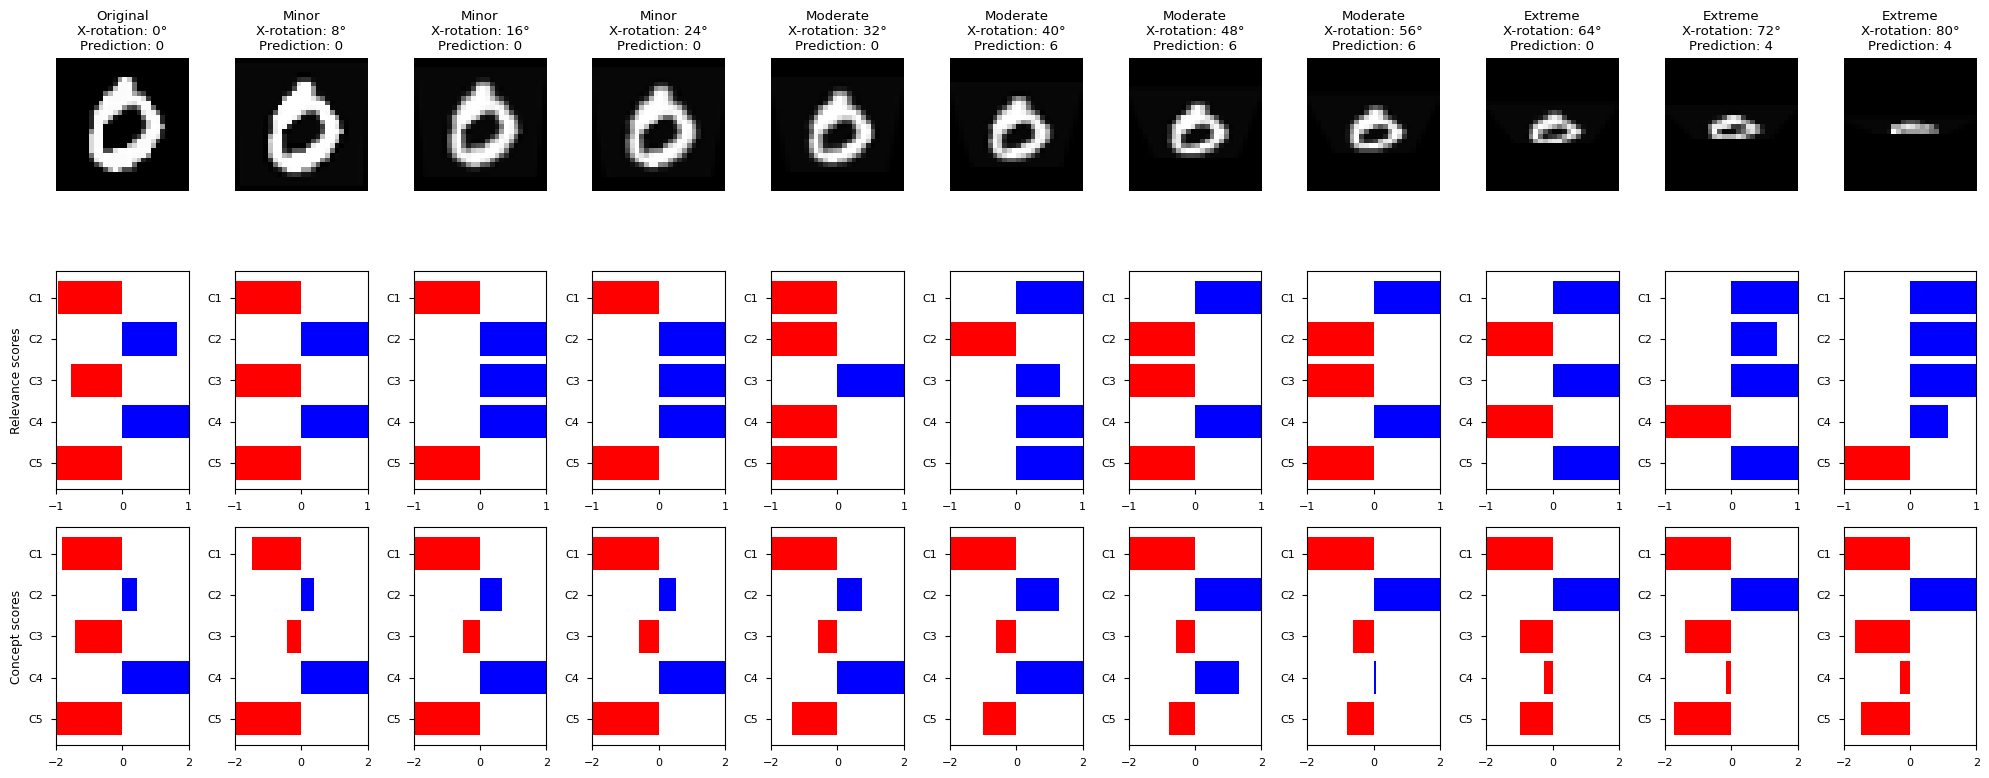


Analyzing Y-axis rotations for digit 0


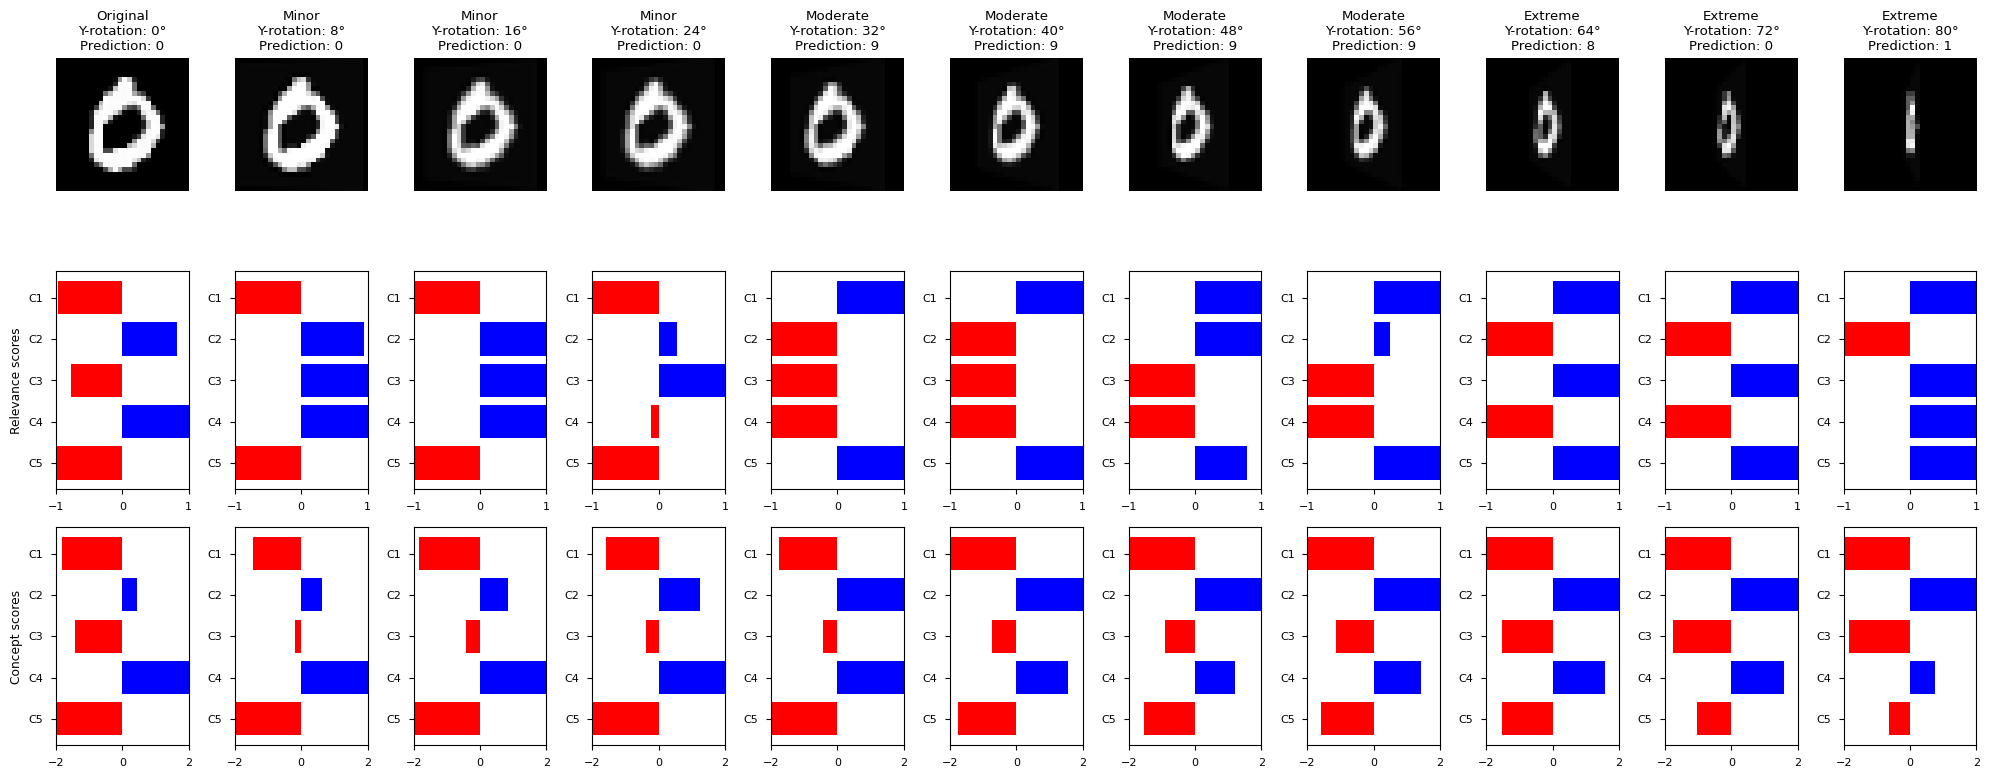


Analyzing Z-axis rotations for digit 0


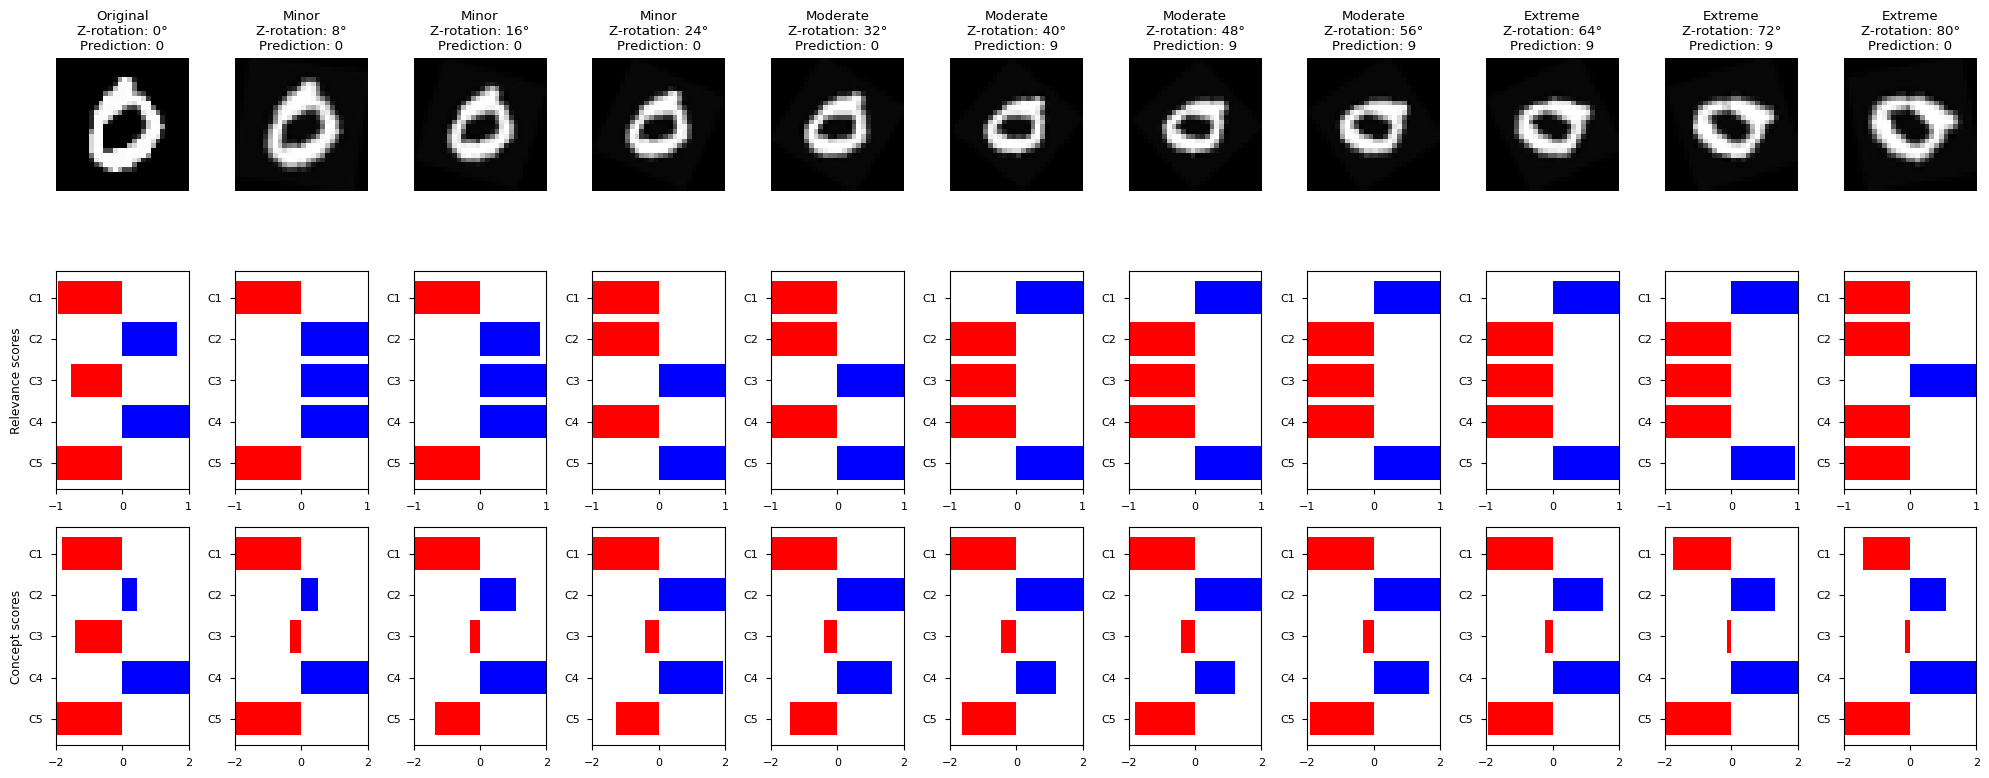


Analyzing digit 1

Analyzing X-axis rotations for digit 1


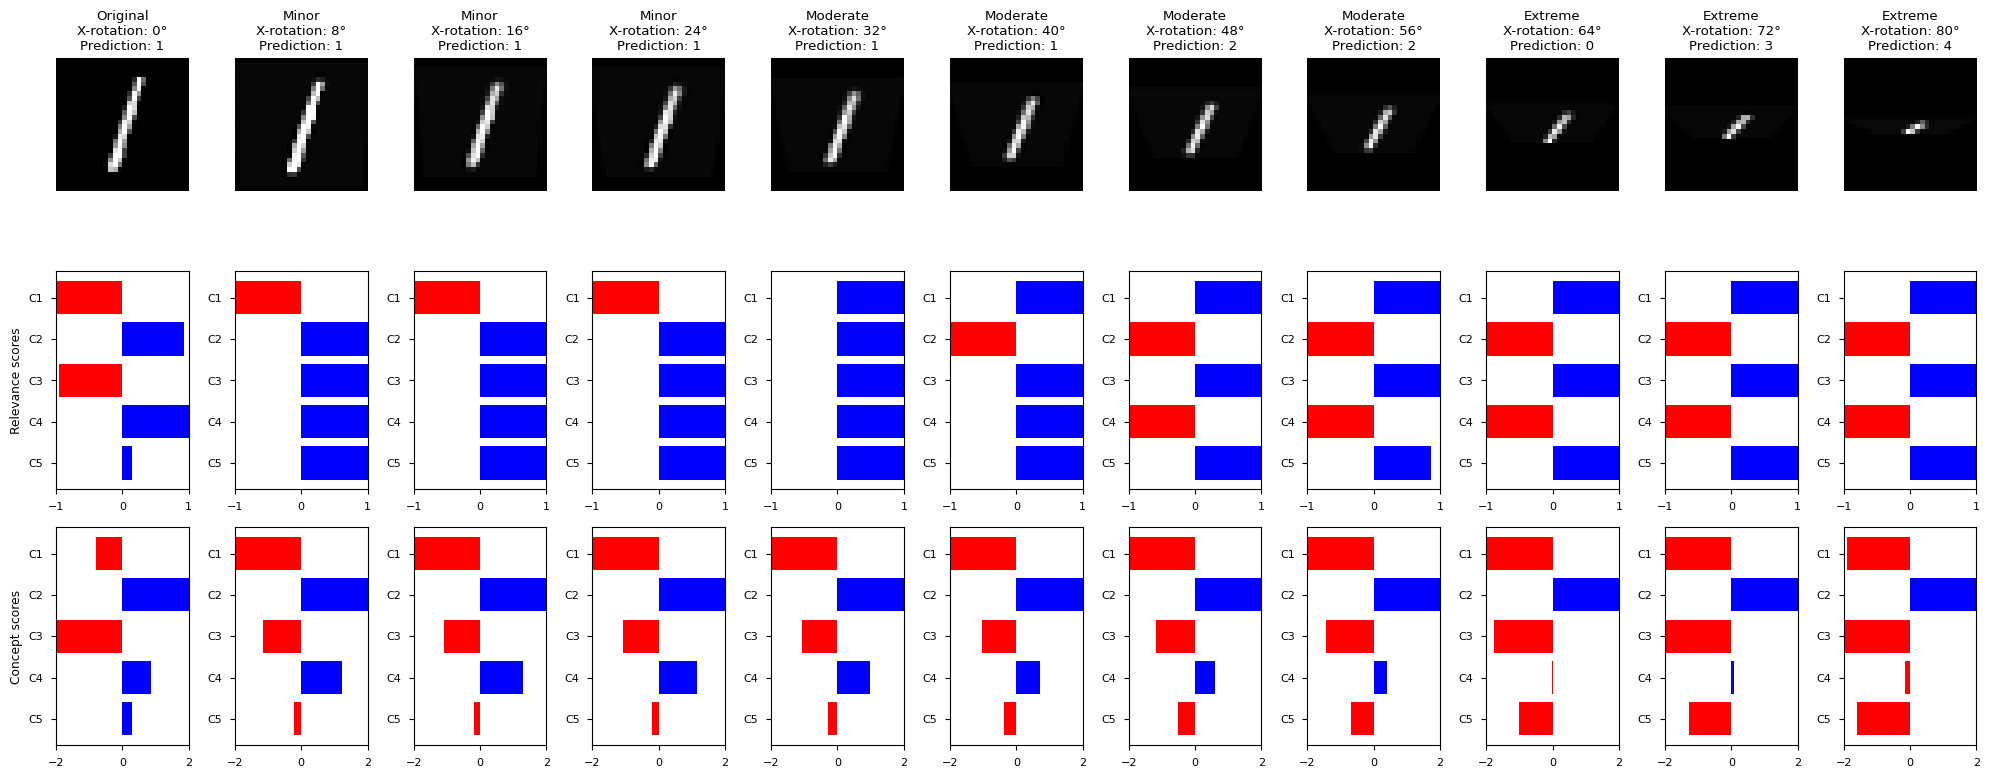


Analyzing Y-axis rotations for digit 1


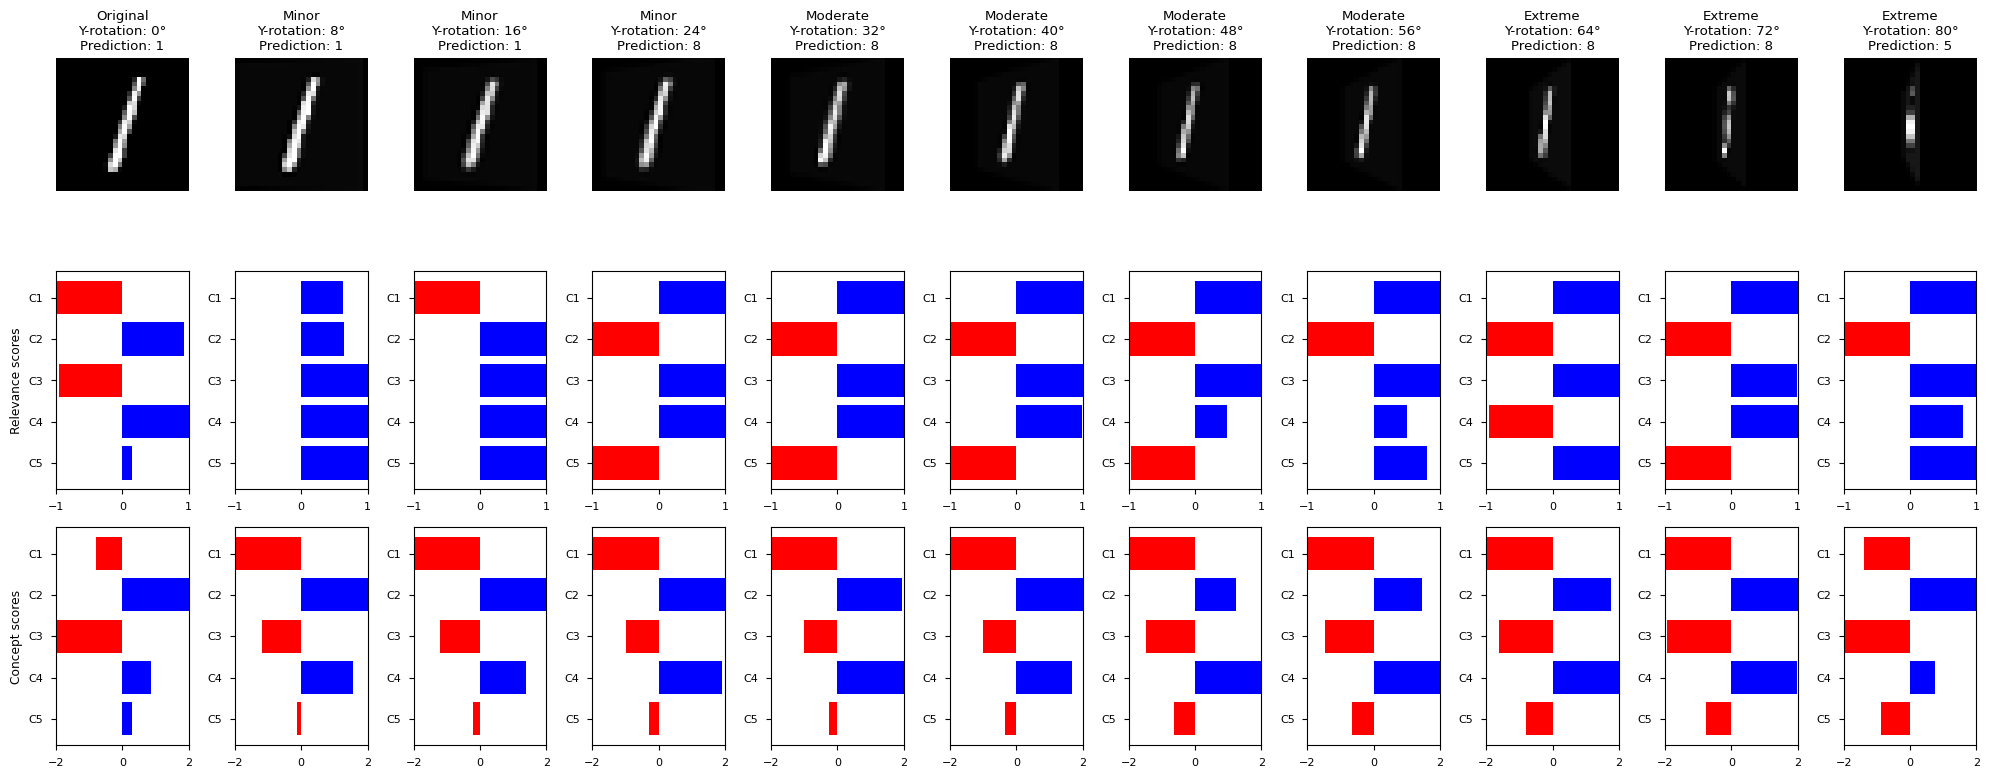


Analyzing Z-axis rotations for digit 1


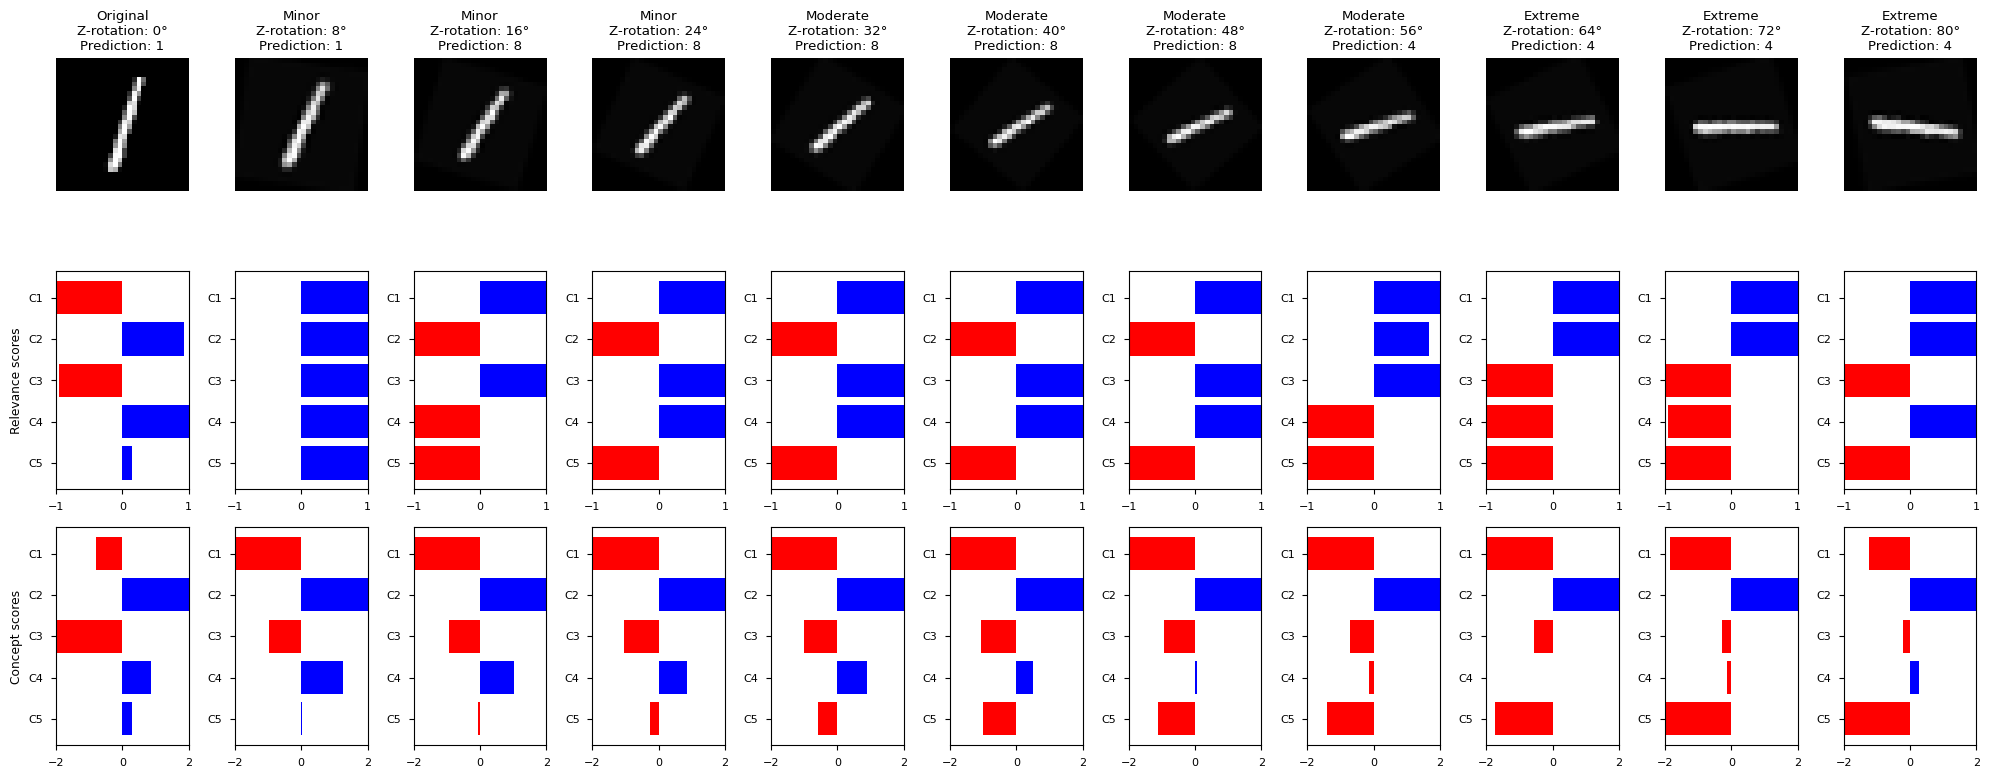


Analyzing digit 2

Analyzing X-axis rotations for digit 2


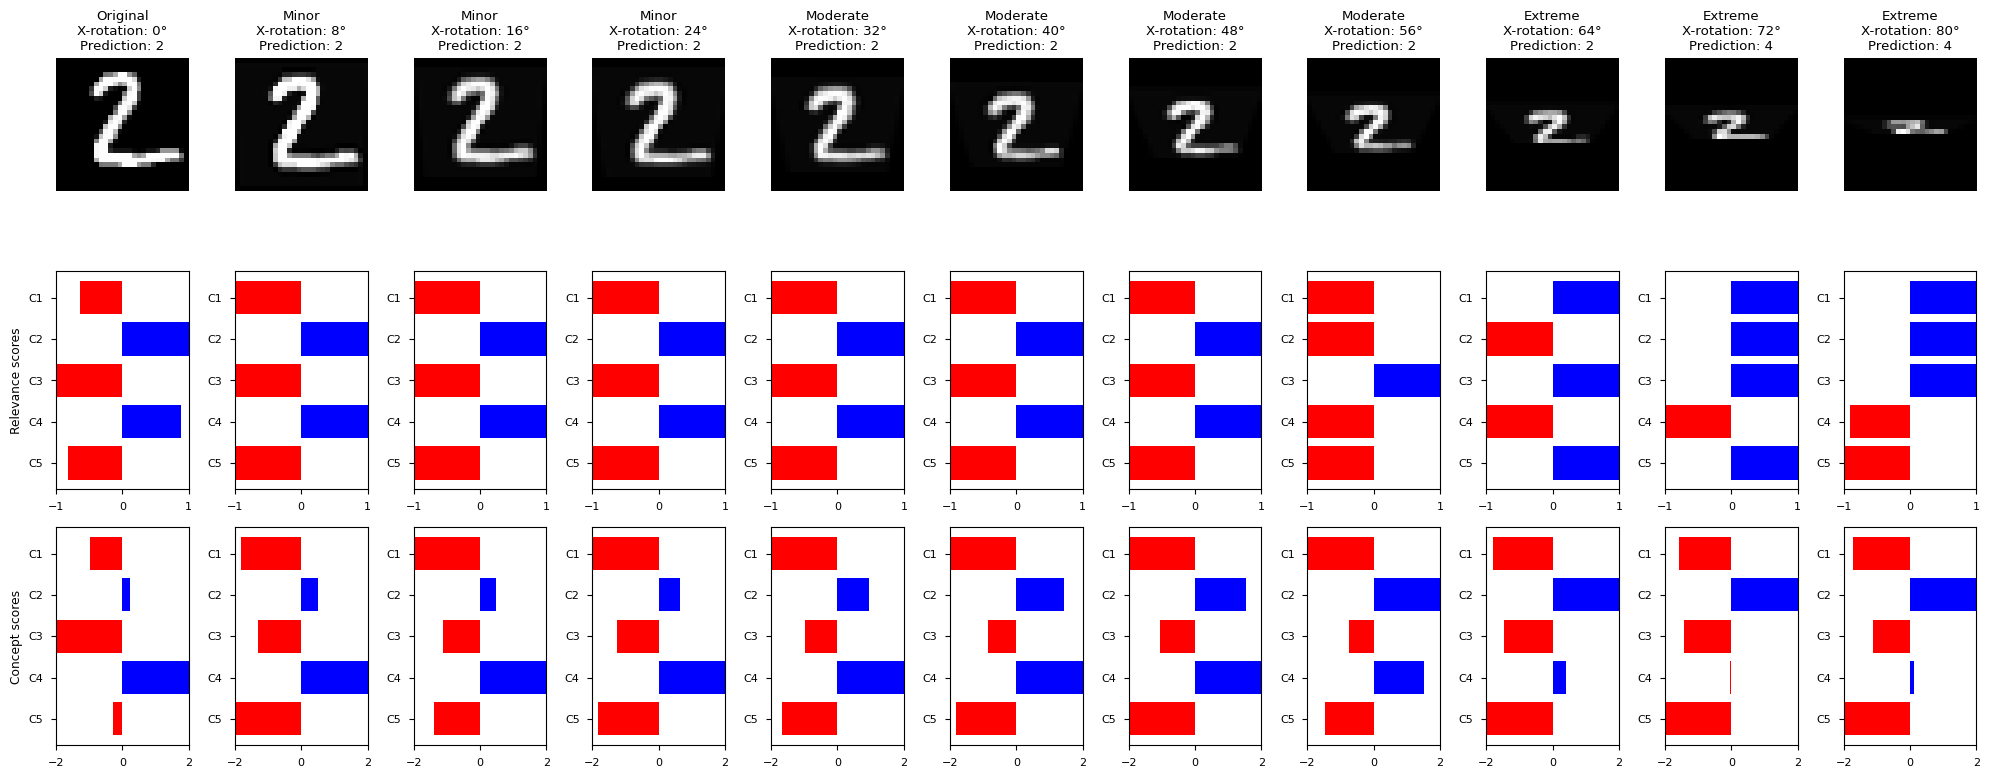


Analyzing Y-axis rotations for digit 2


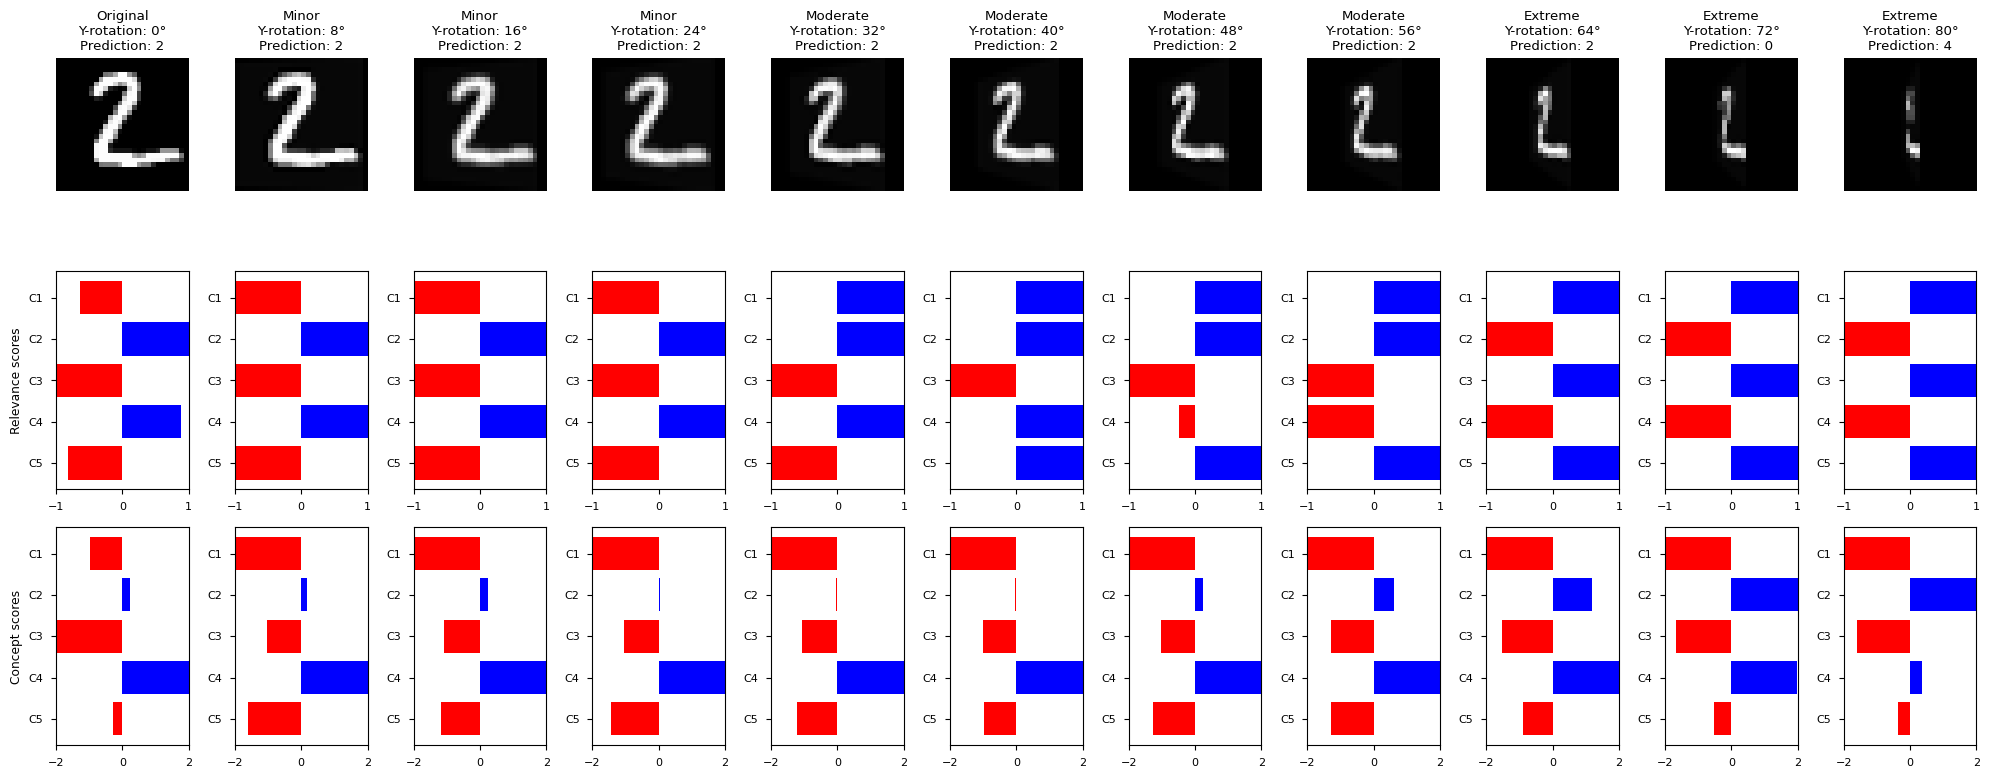


Analyzing Z-axis rotations for digit 2


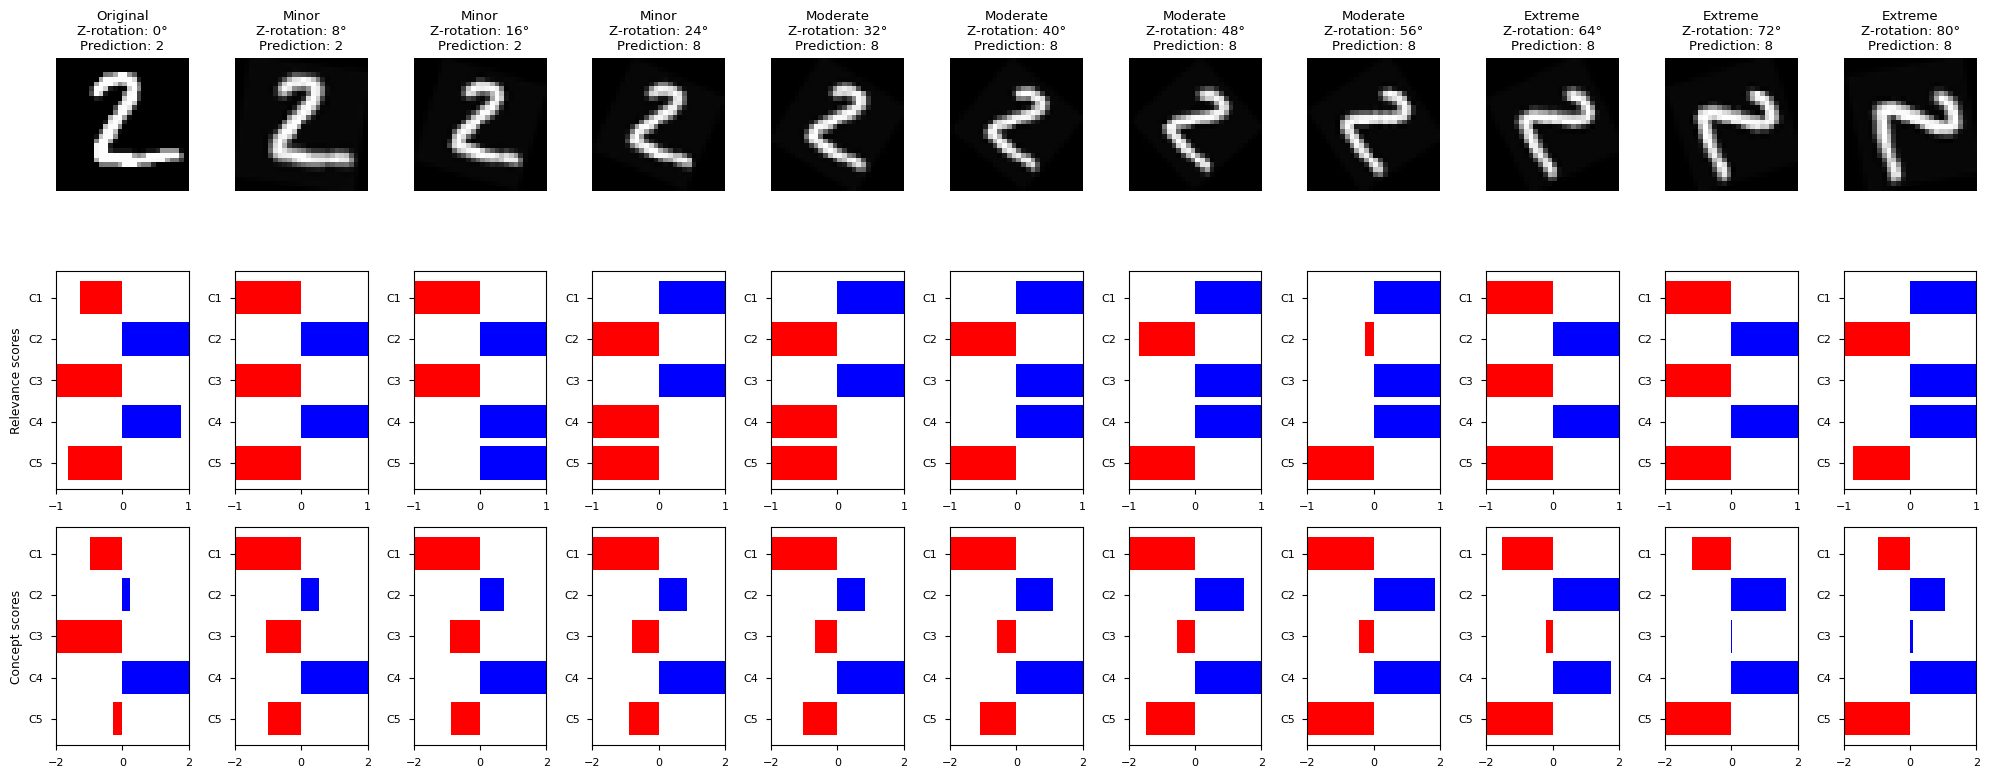


Analyzing digit 3

Analyzing X-axis rotations for digit 3


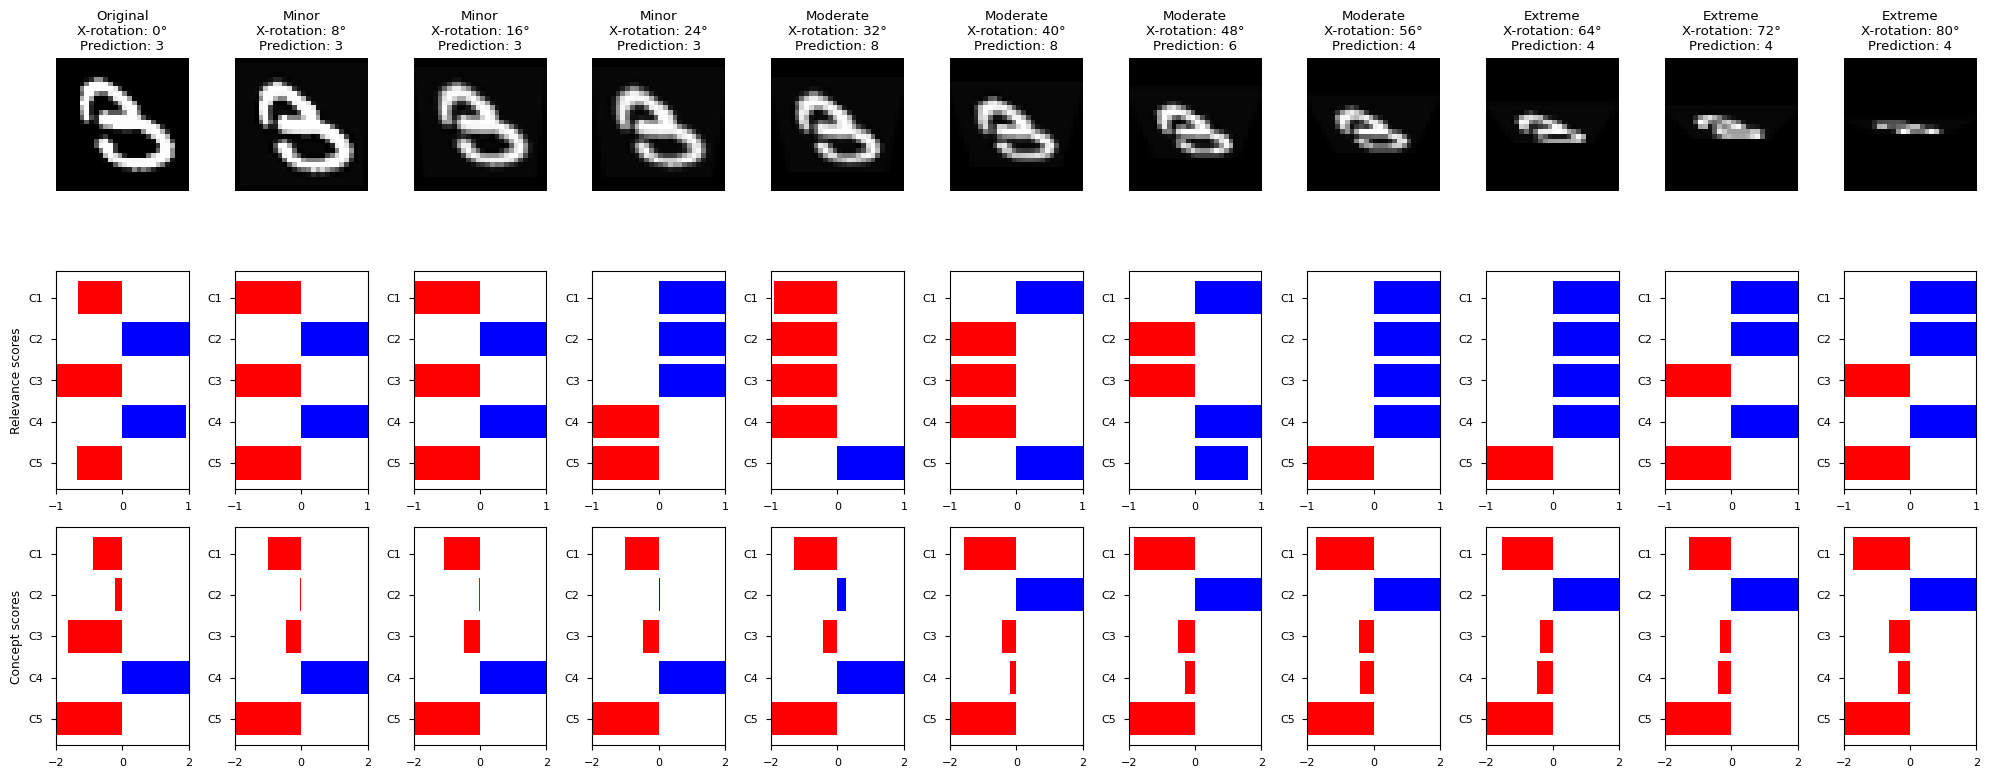


Analyzing Y-axis rotations for digit 3


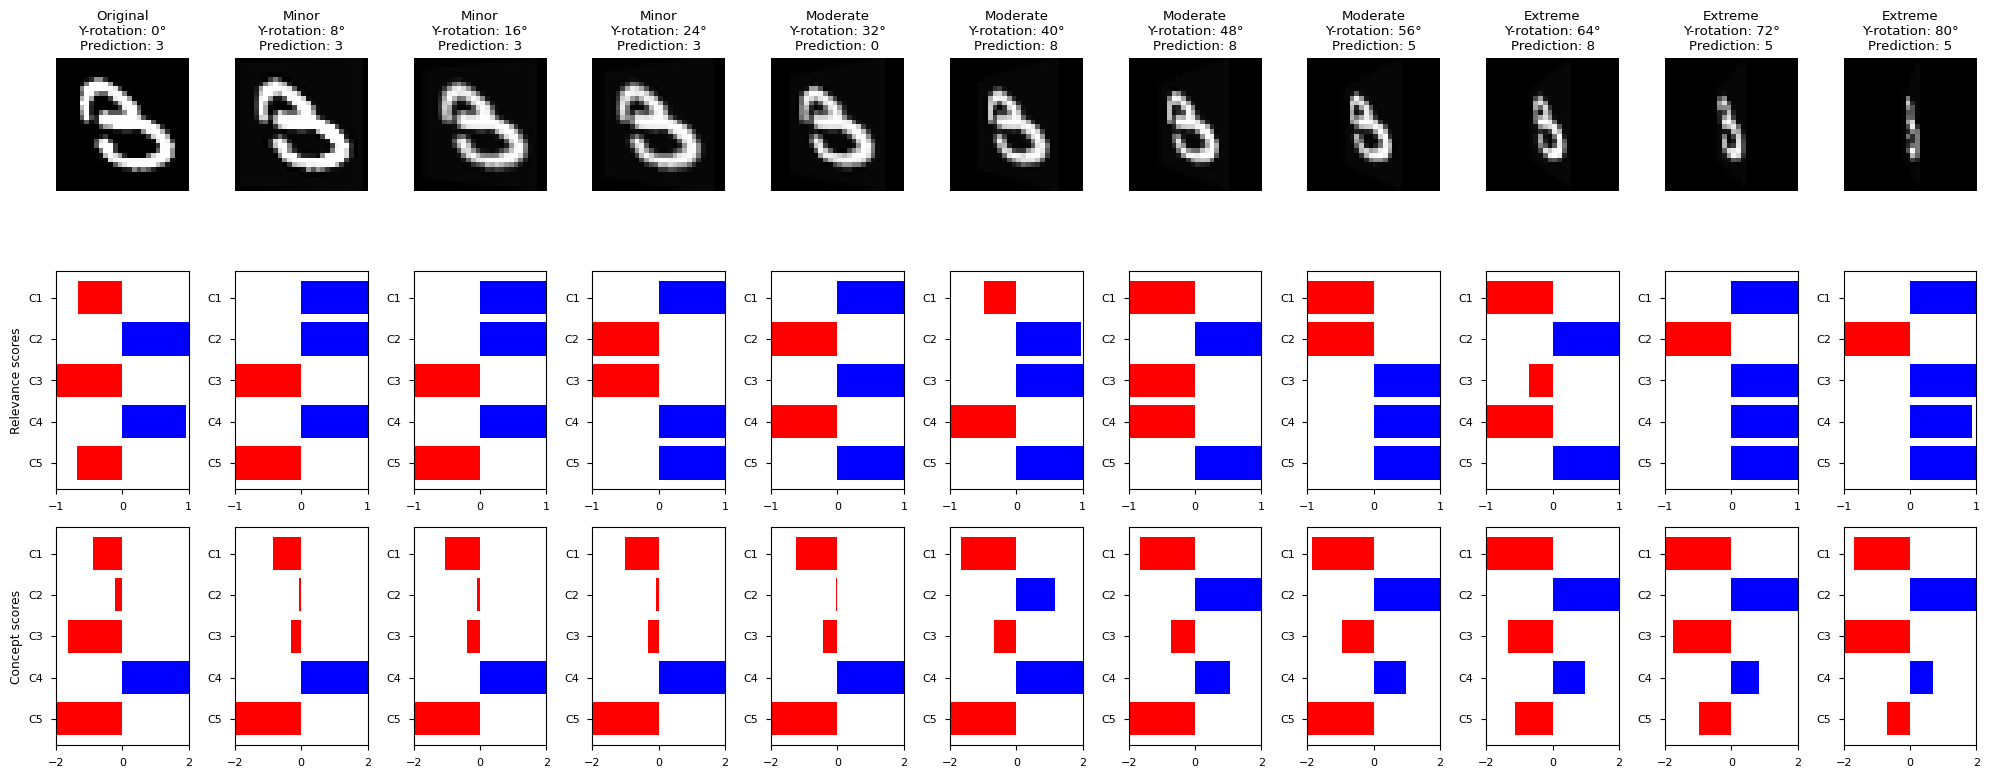


Analyzing Z-axis rotations for digit 3


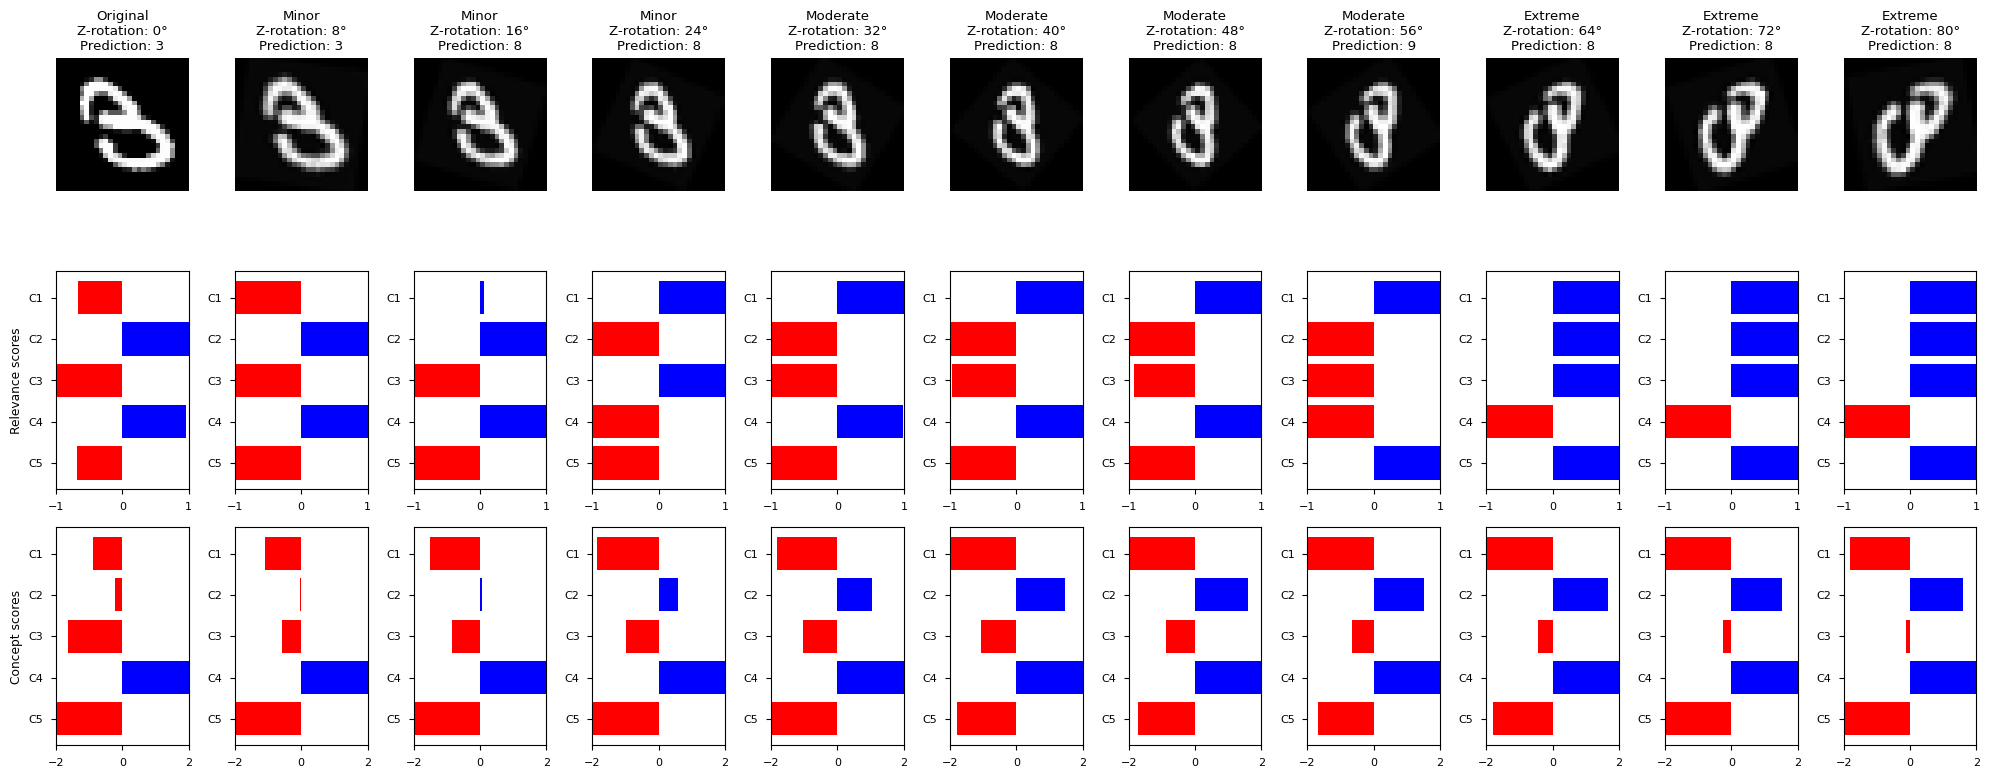


Analyzing digit 4

Analyzing X-axis rotations for digit 4


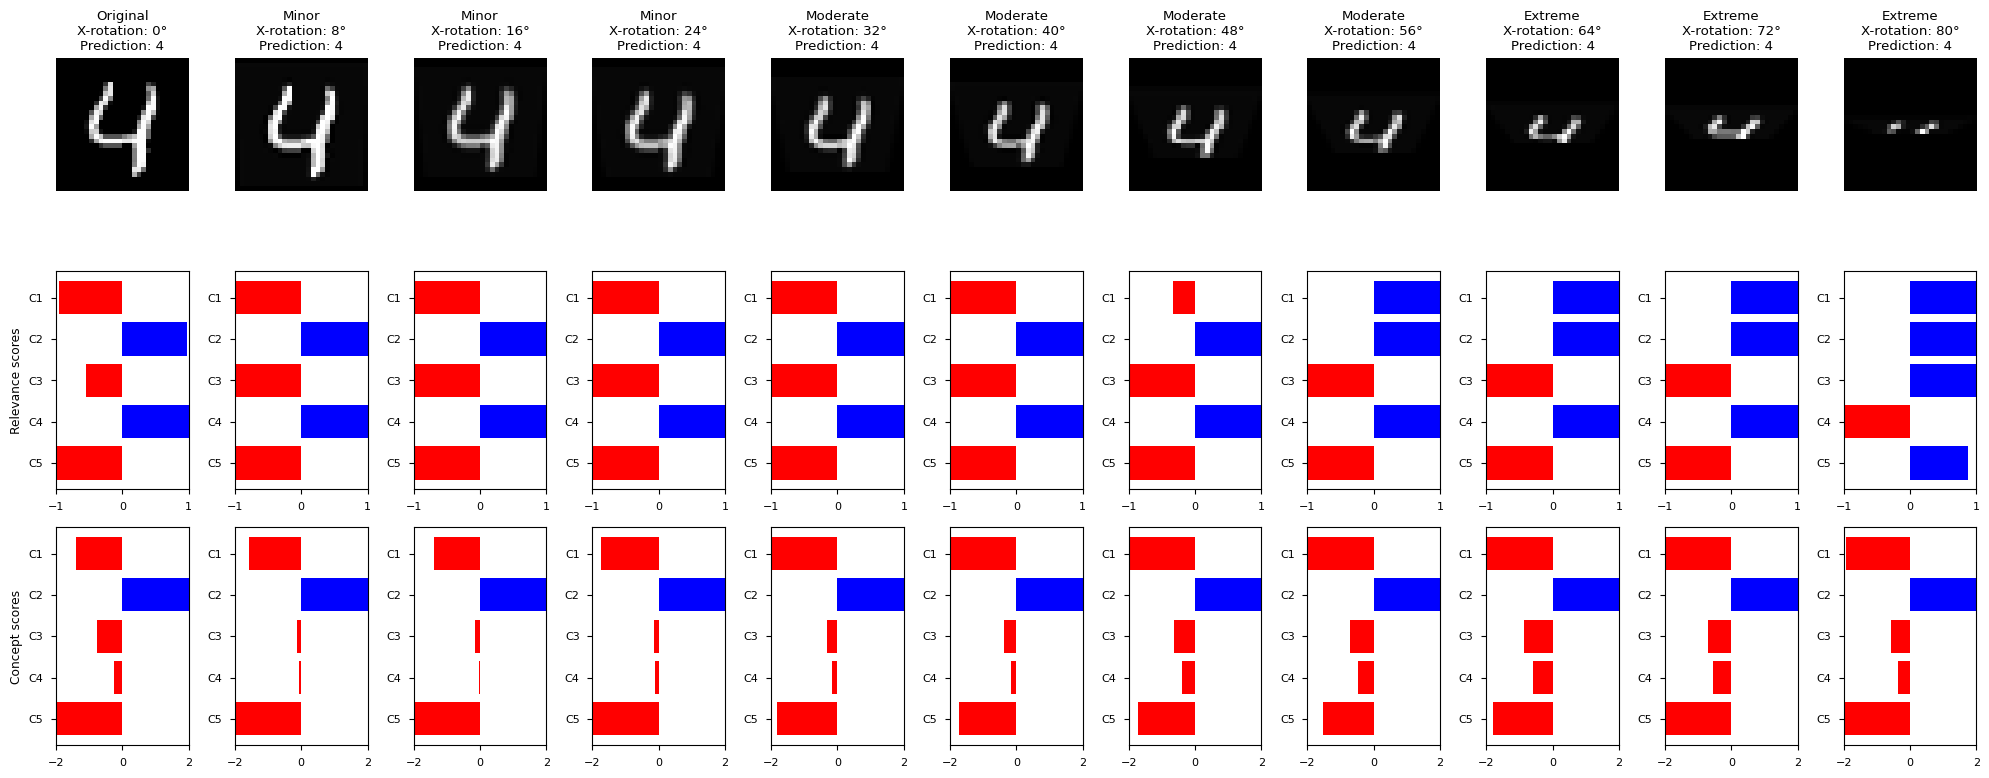


Analyzing Y-axis rotations for digit 4


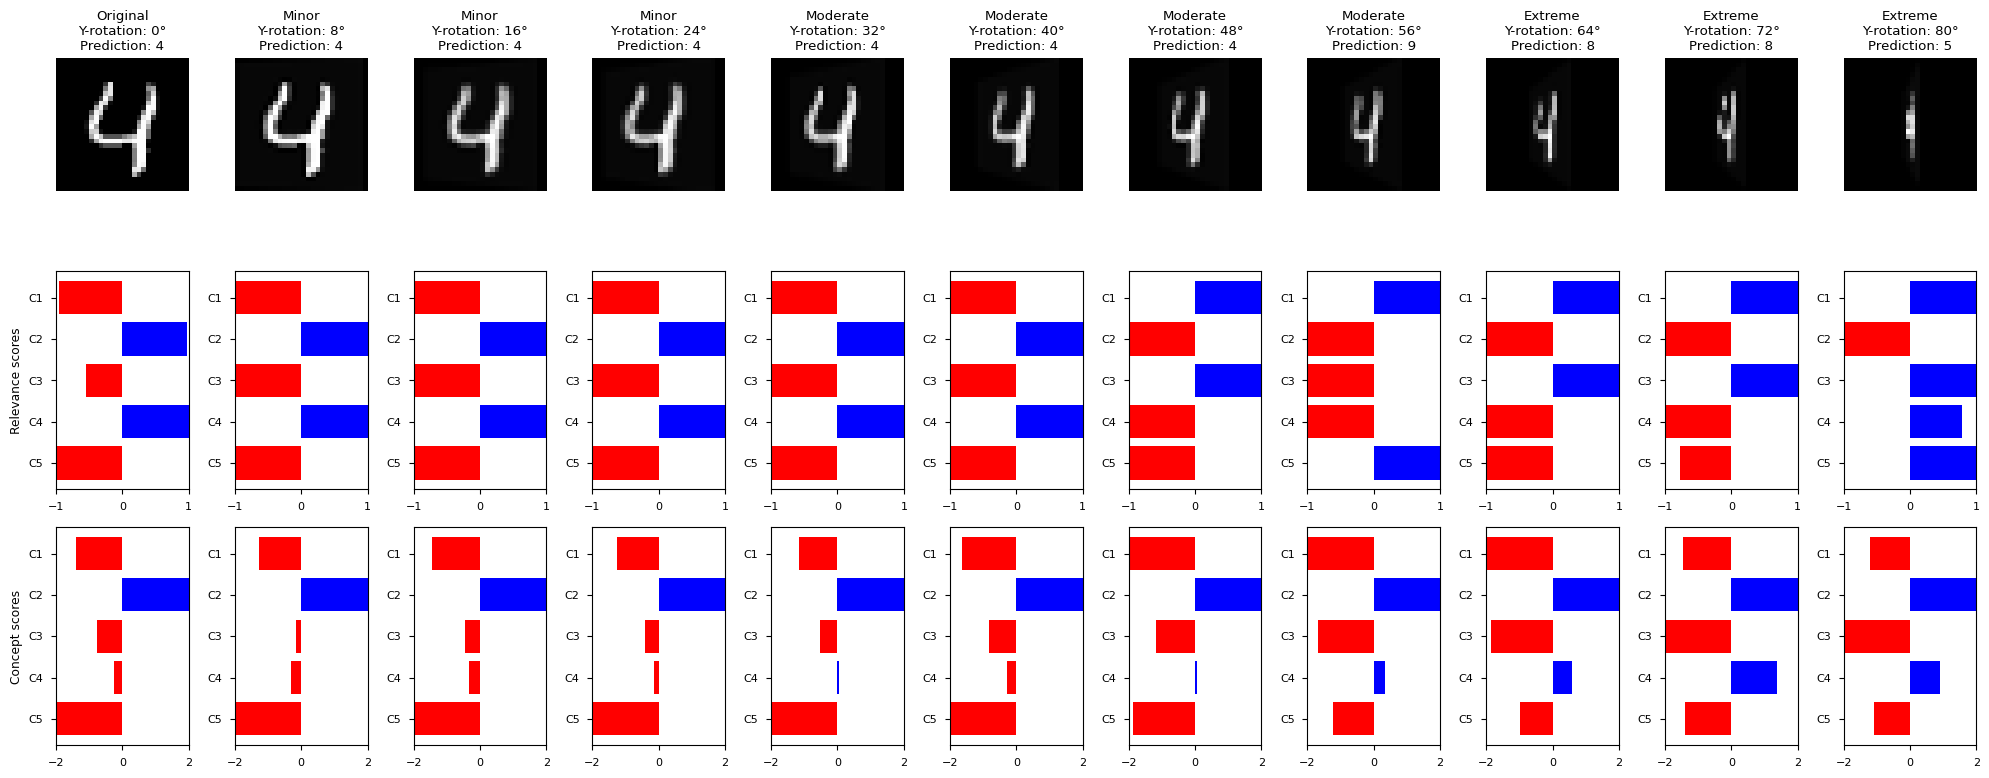


Analyzing Z-axis rotations for digit 4


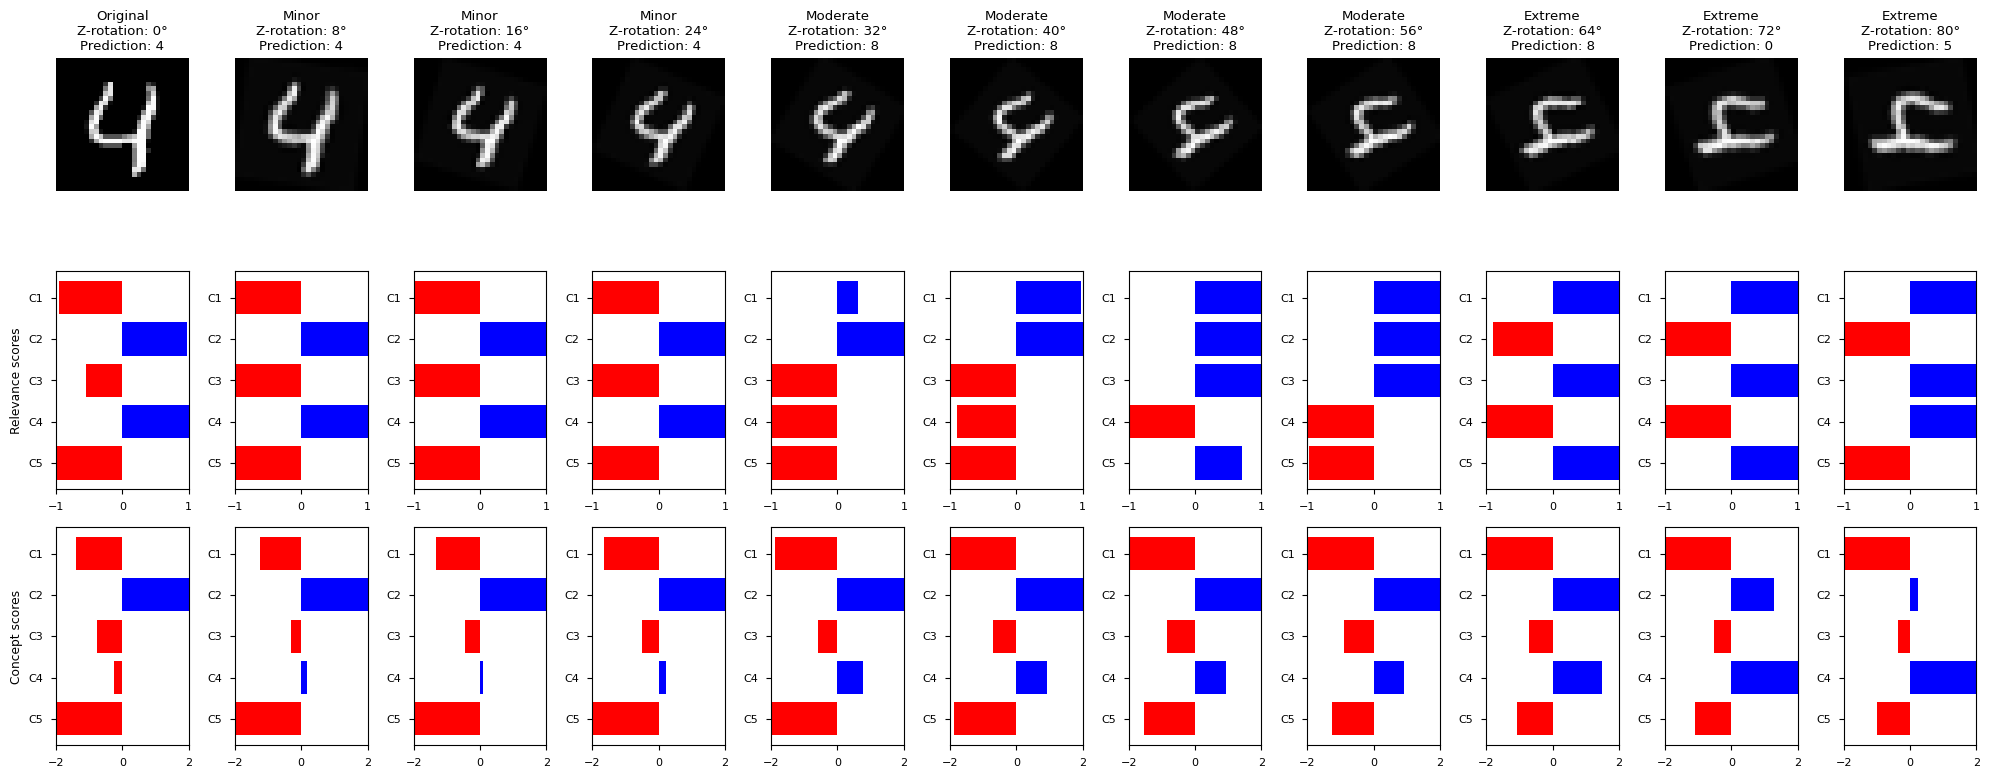


Analyzing digit 5

Analyzing X-axis rotations for digit 5


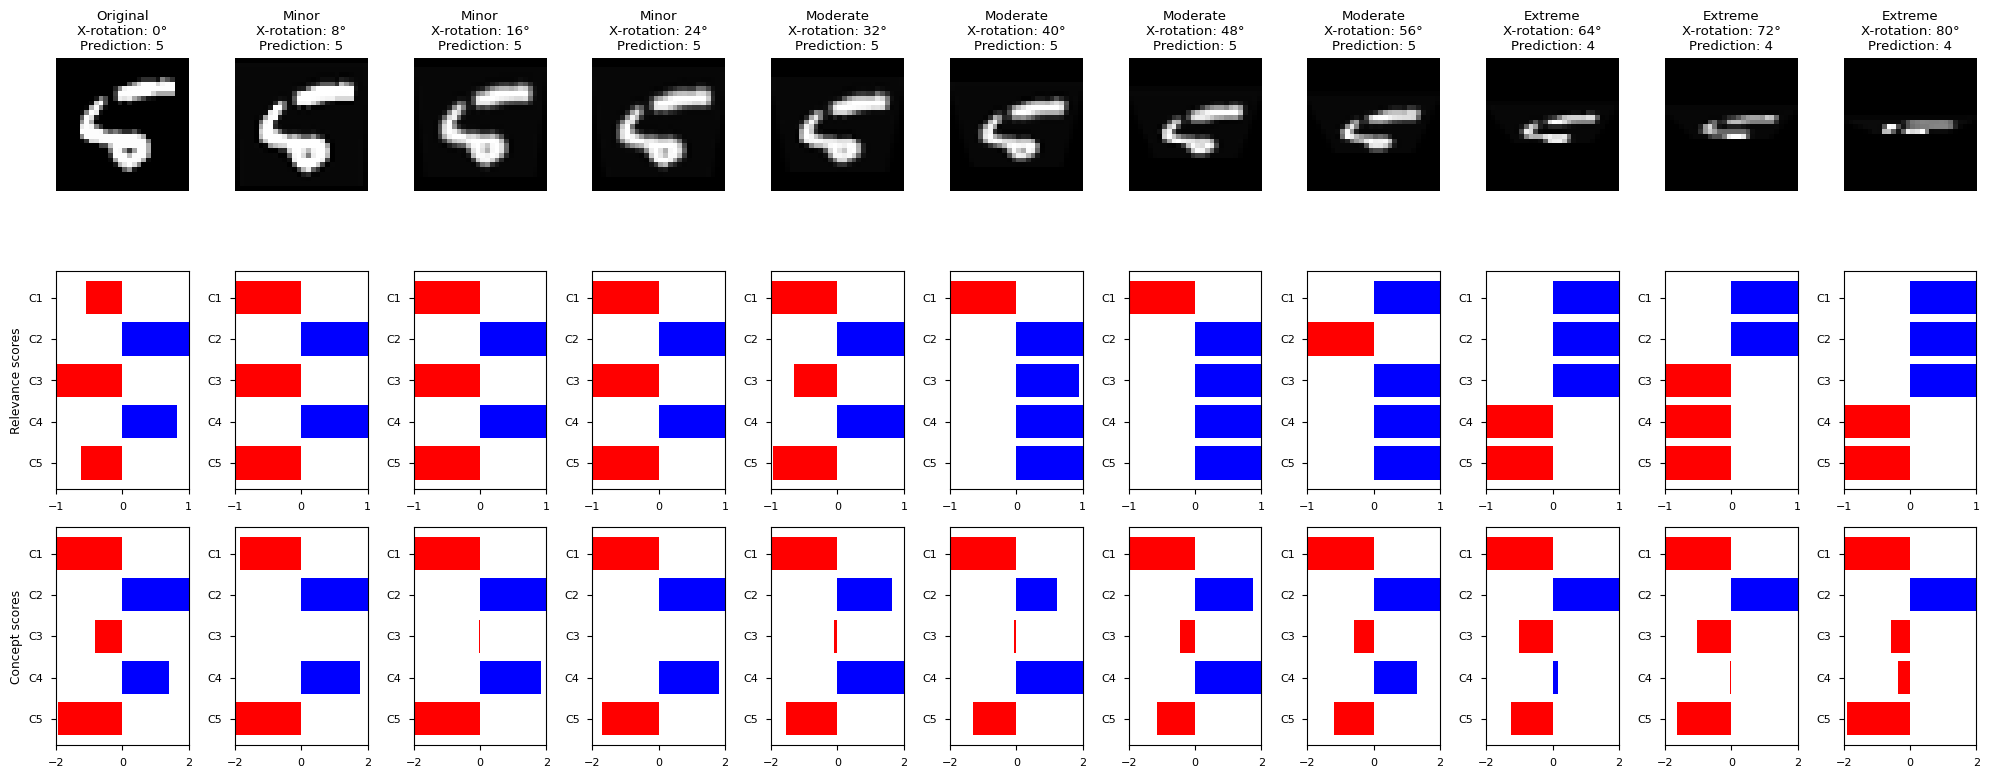


Analyzing Y-axis rotations for digit 5


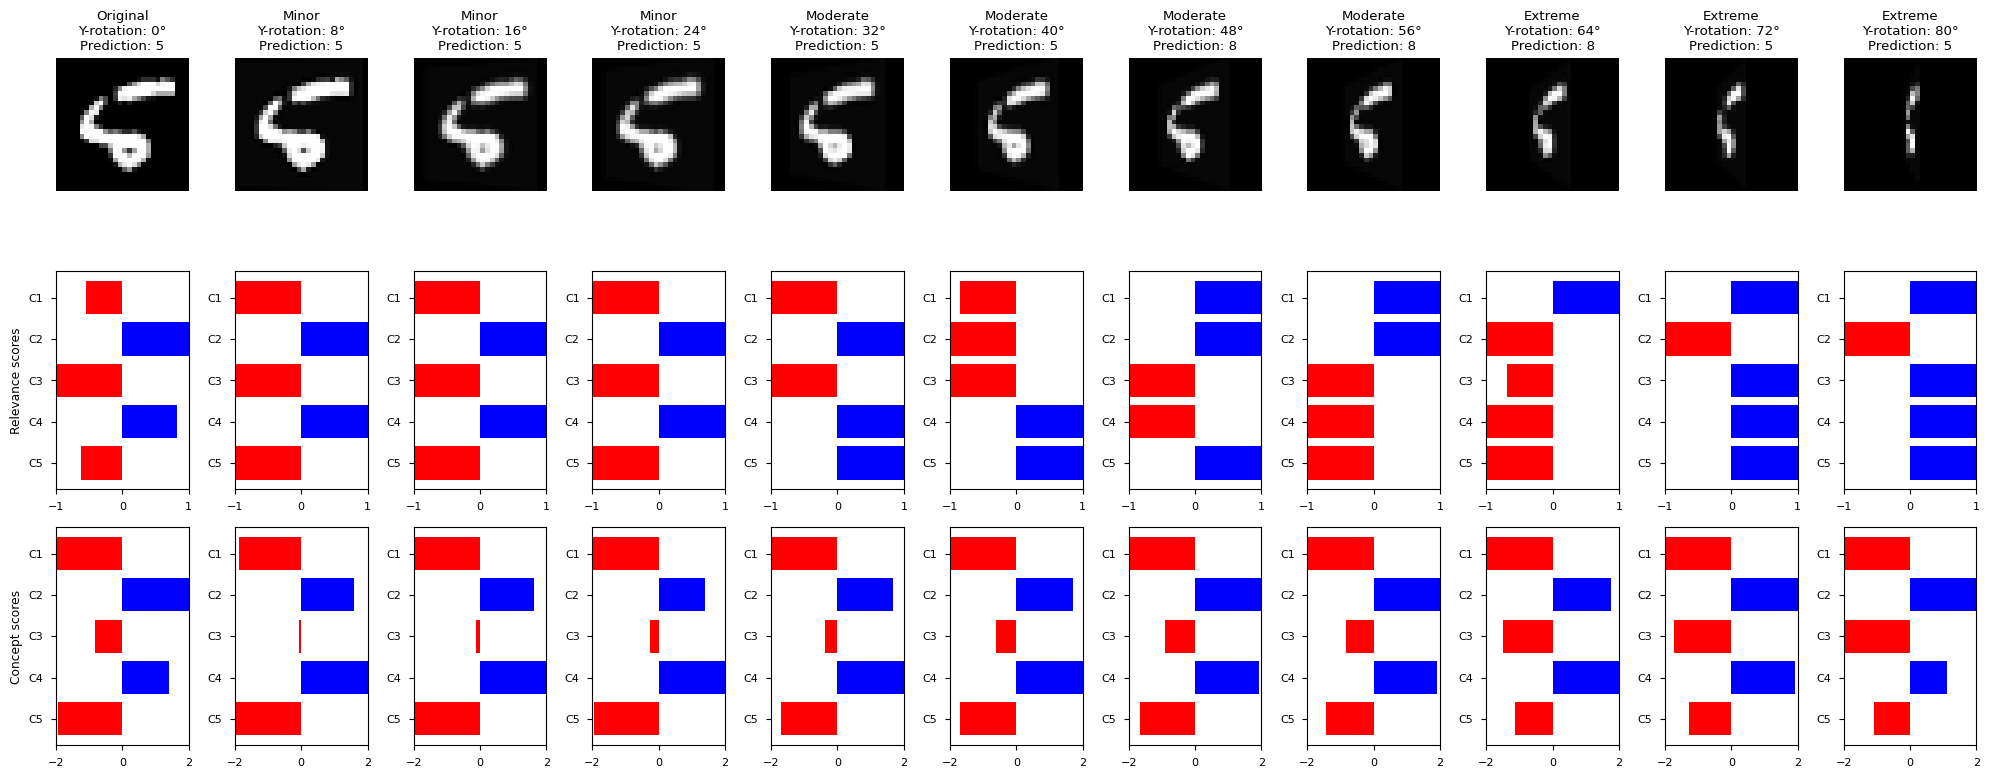


Analyzing Z-axis rotations for digit 5


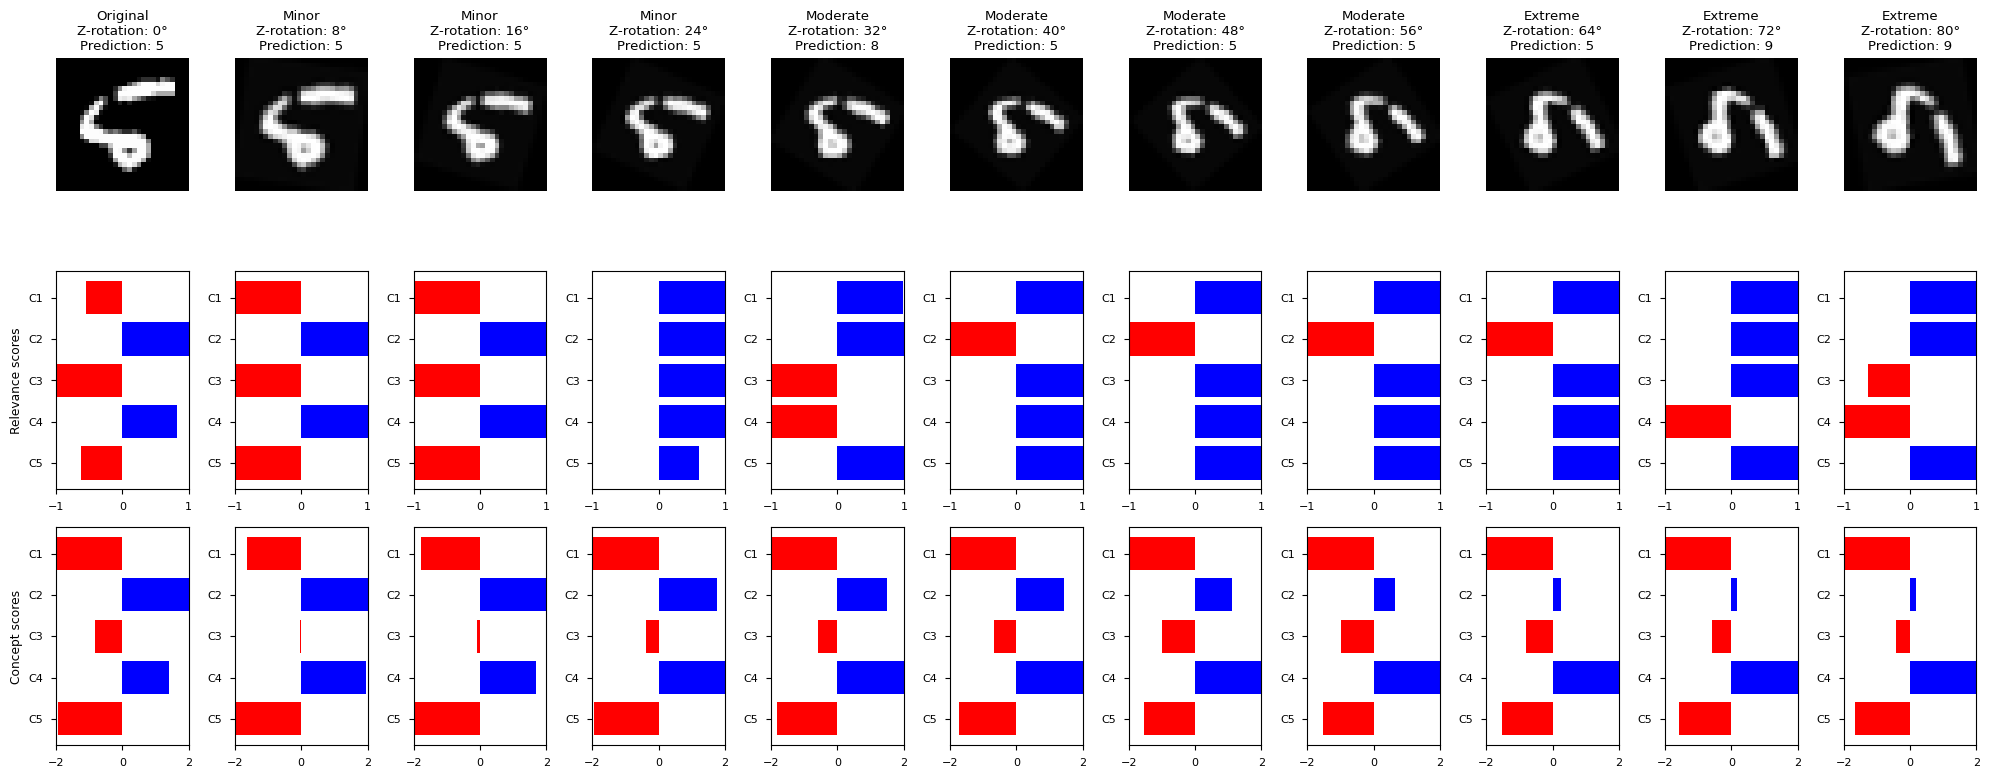


Analyzing digit 6

Analyzing X-axis rotations for digit 6


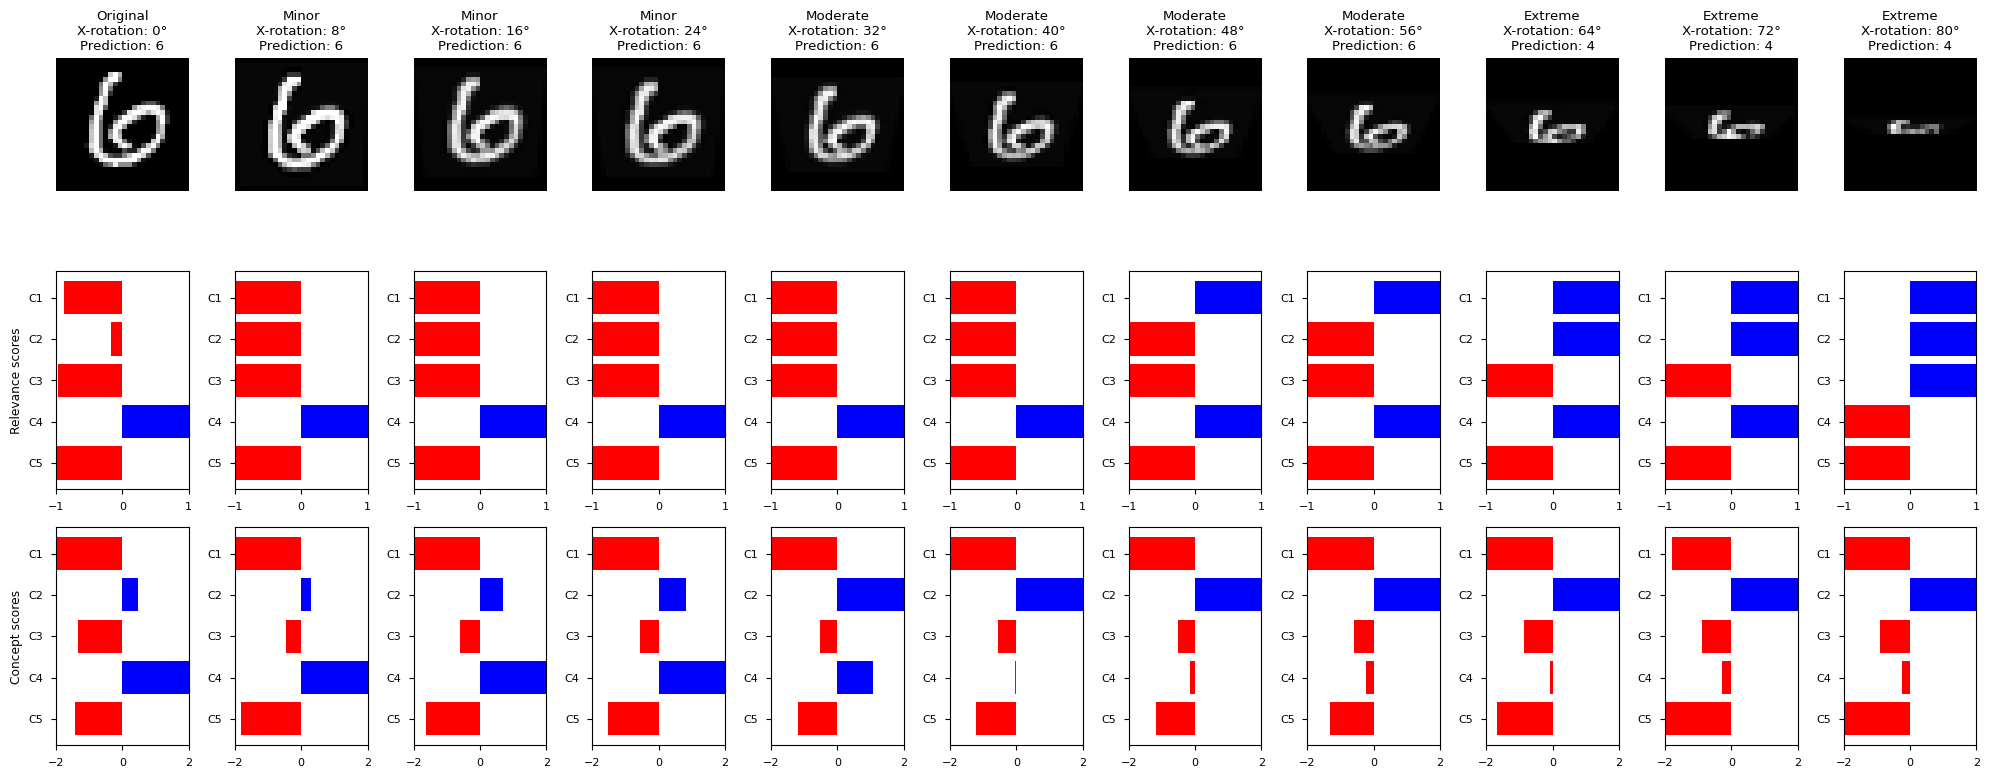


Analyzing Y-axis rotations for digit 6


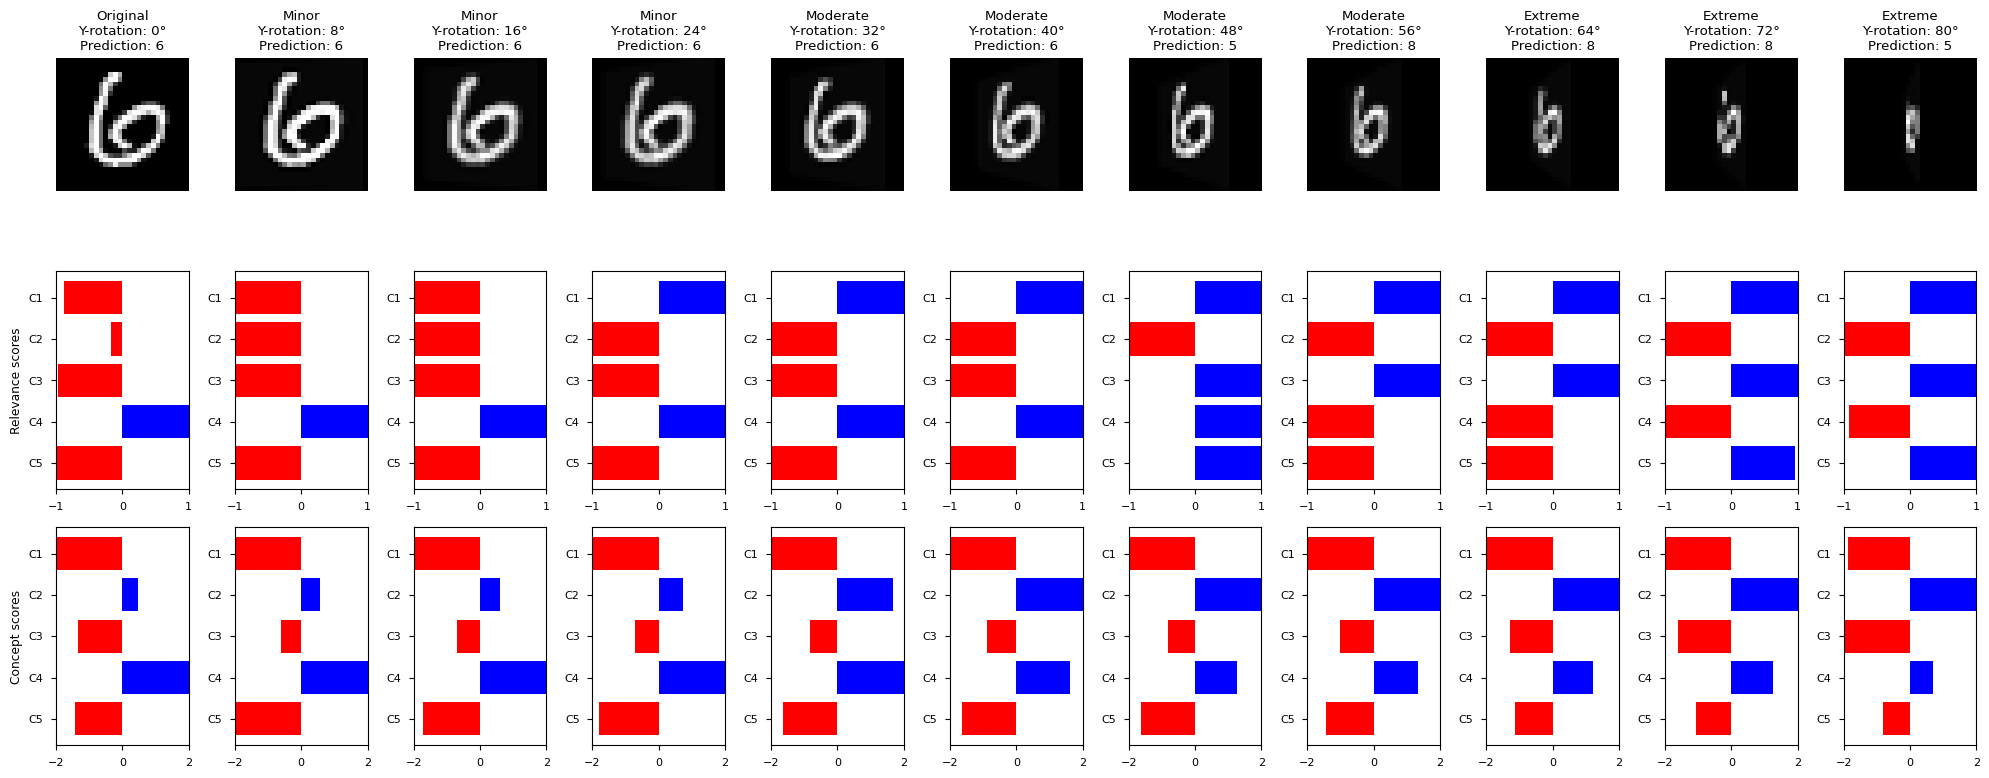


Analyzing Z-axis rotations for digit 6


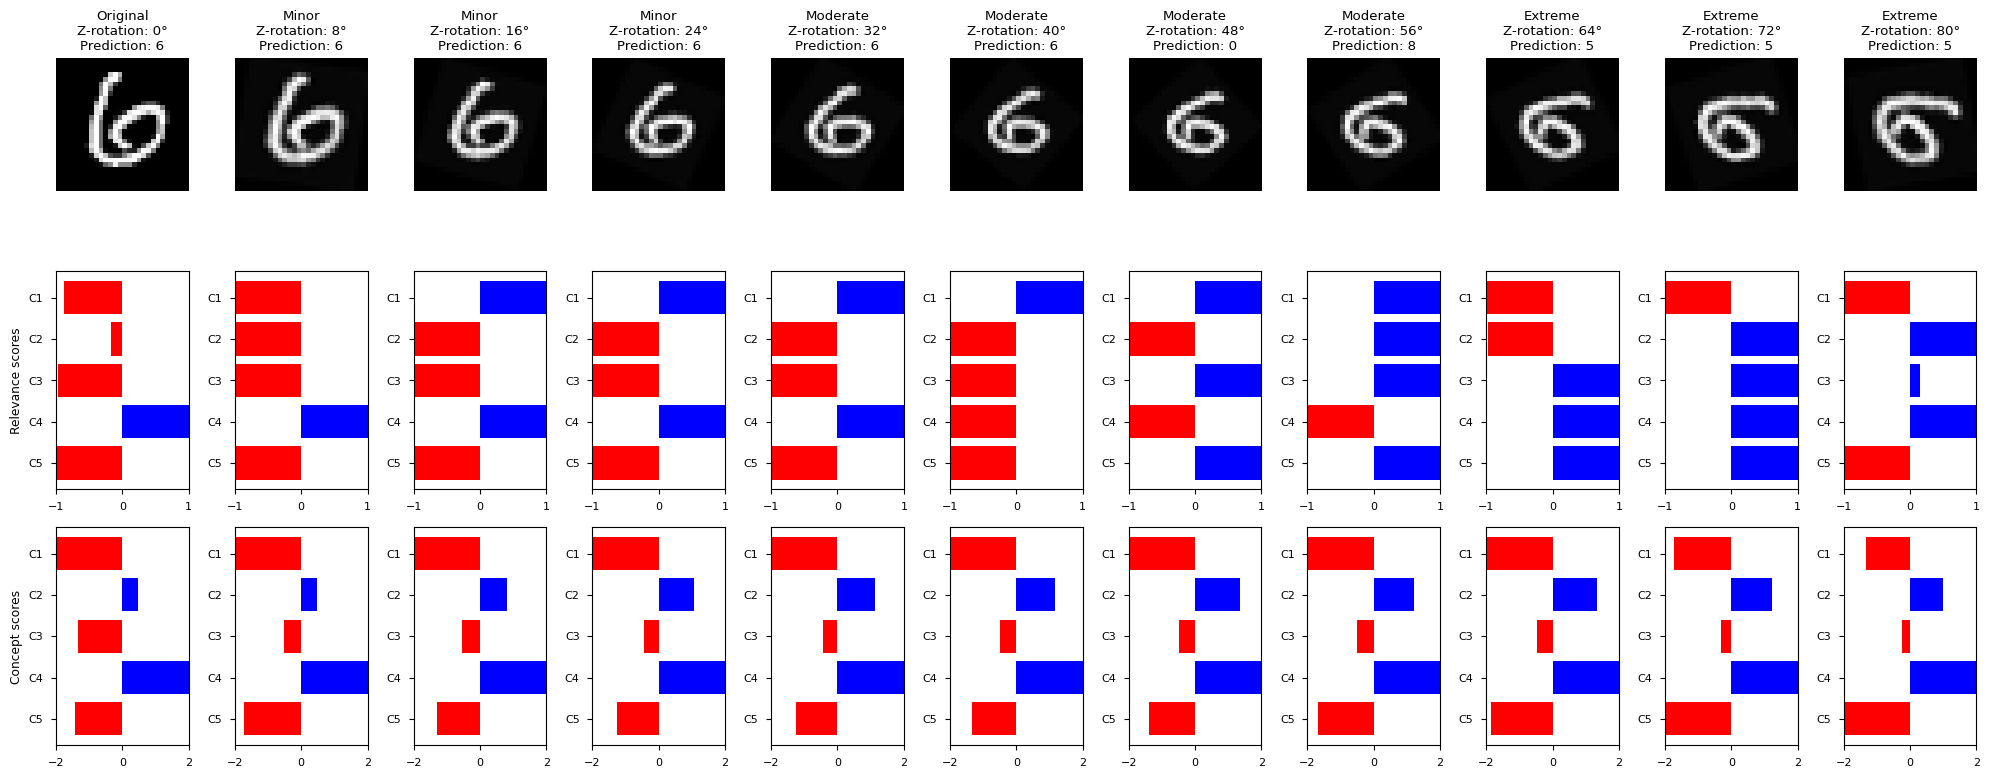


Analyzing digit 7

Analyzing X-axis rotations for digit 7


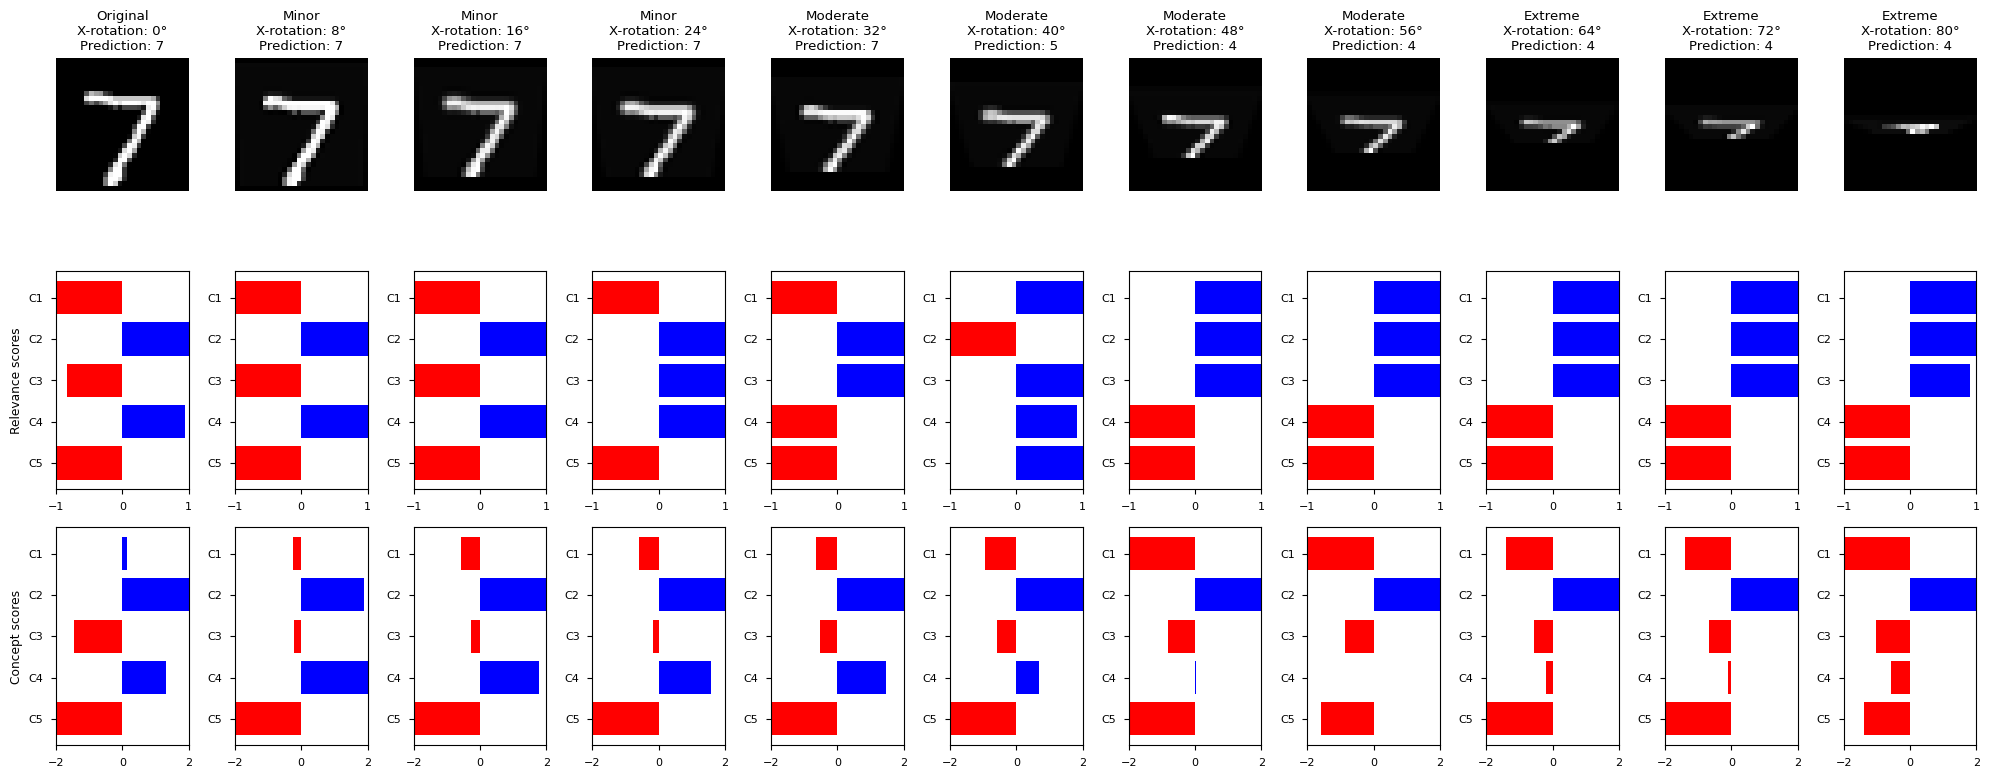


Analyzing Y-axis rotations for digit 7


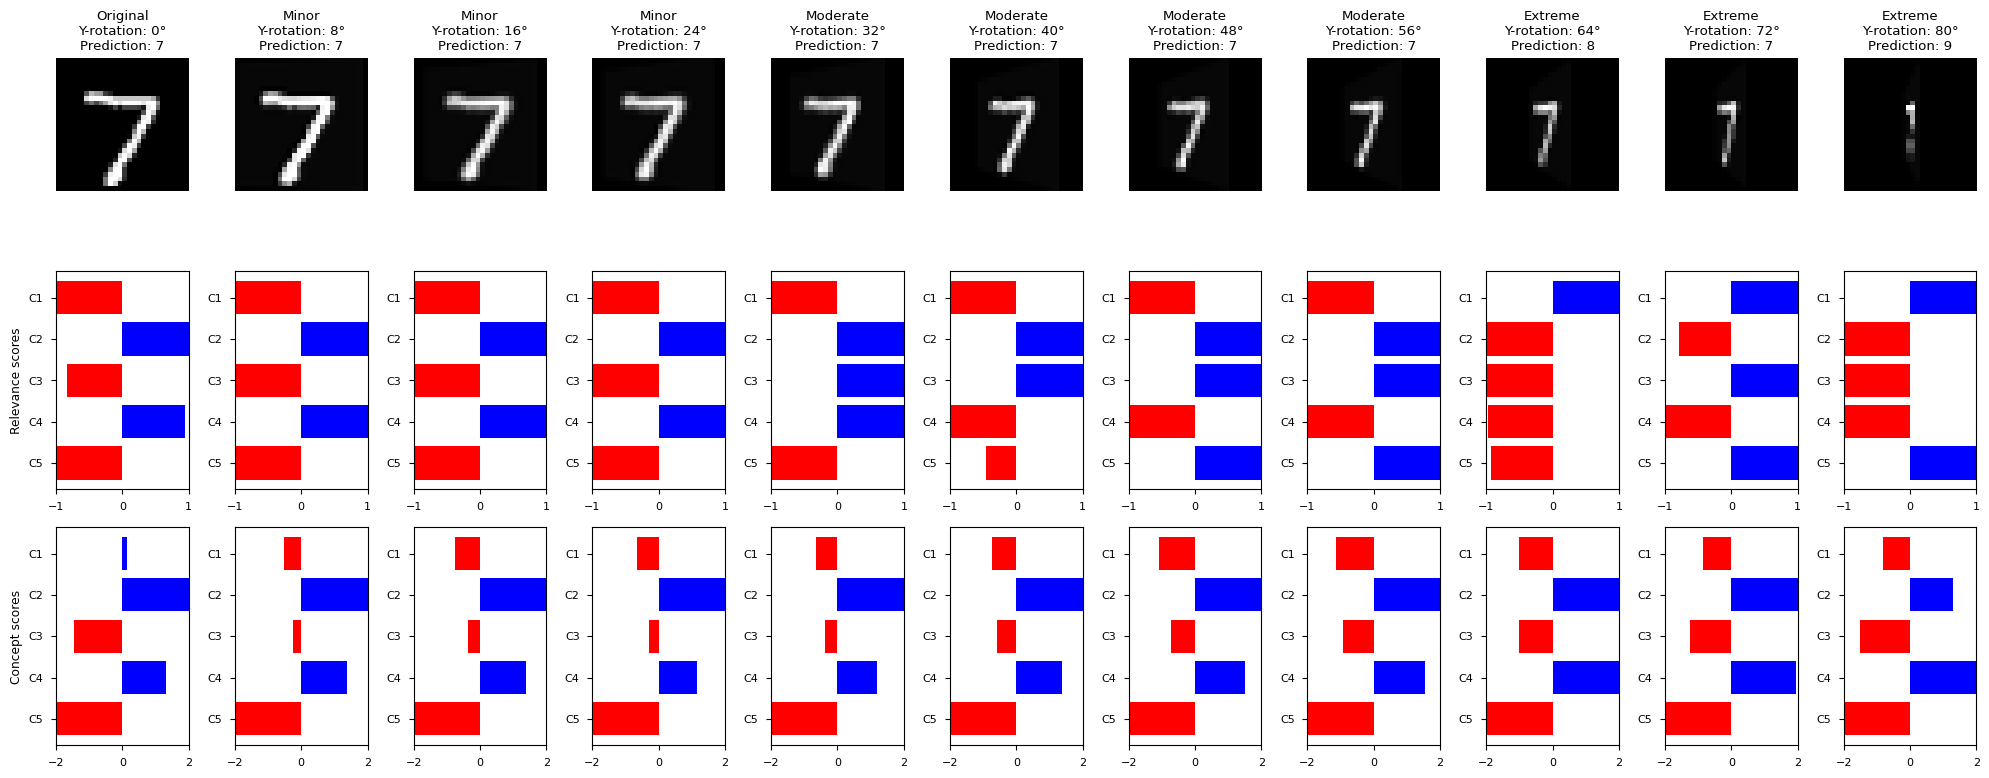


Analyzing Z-axis rotations for digit 7


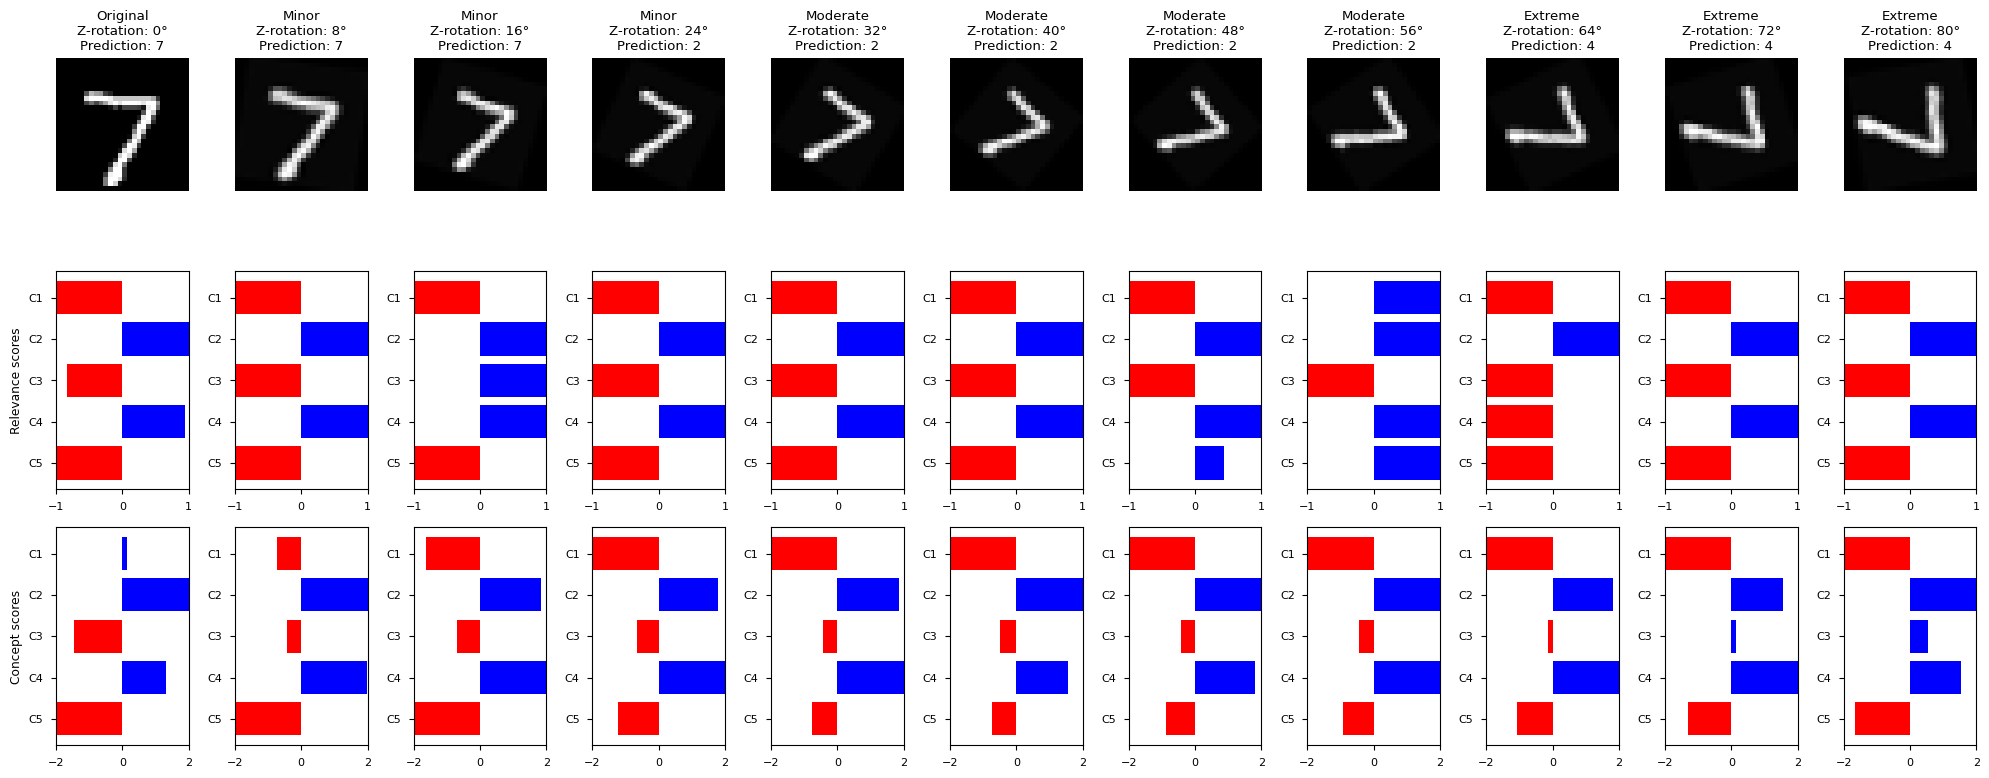


Analyzing digit 8

Analyzing X-axis rotations for digit 8


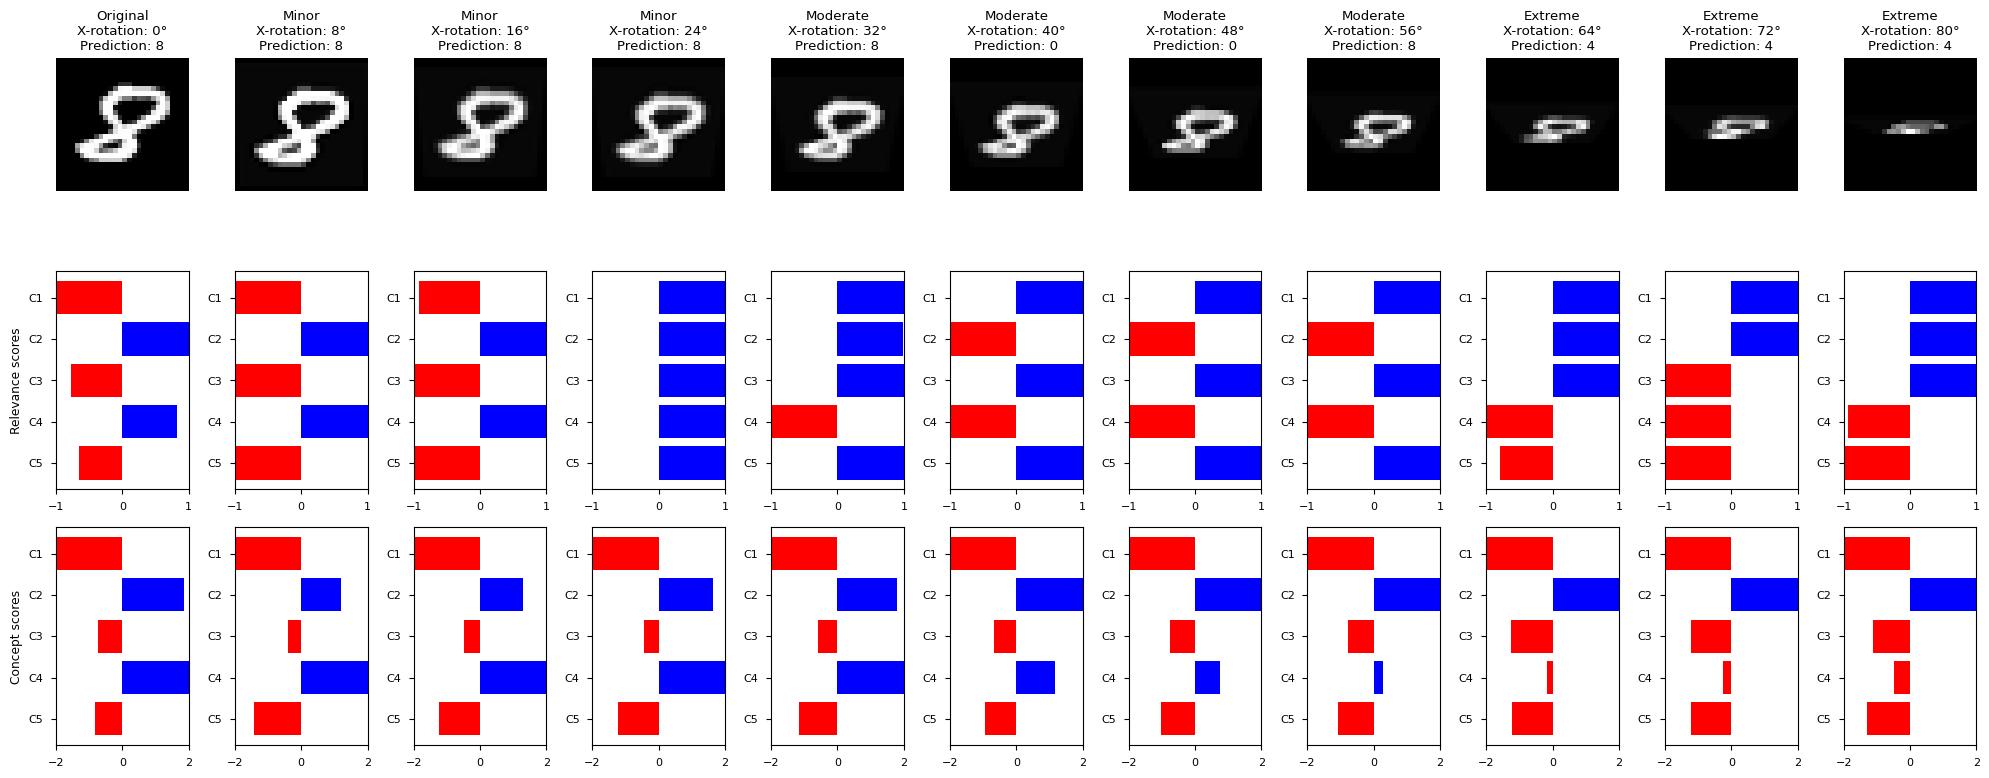


Analyzing Y-axis rotations for digit 8


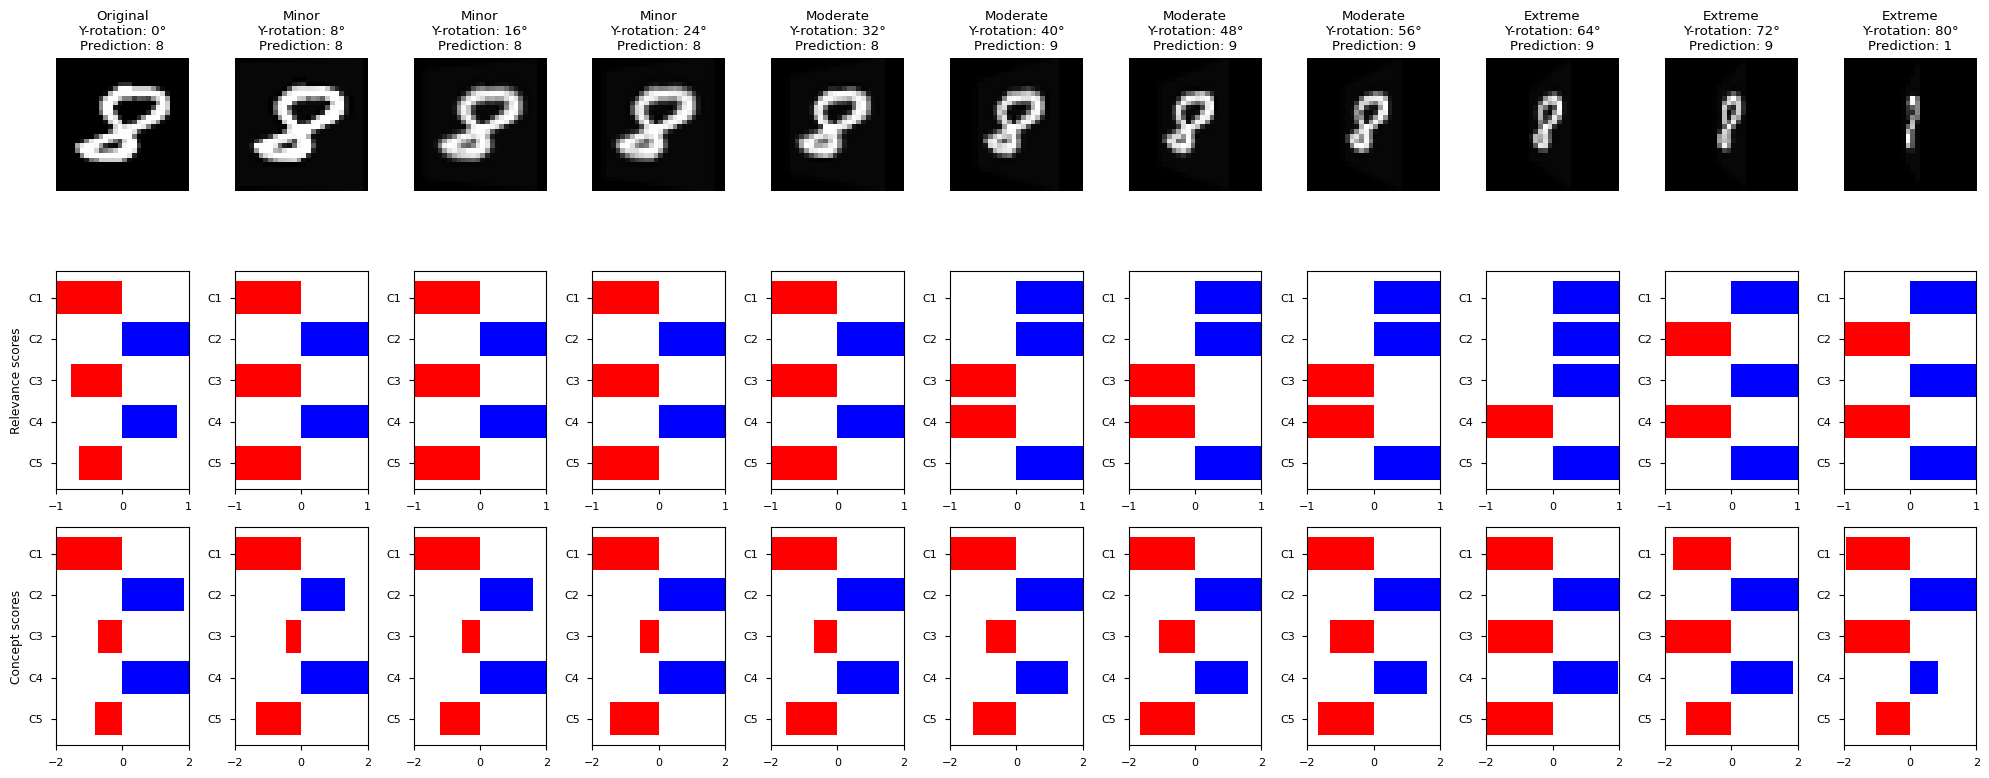


Analyzing Z-axis rotations for digit 8


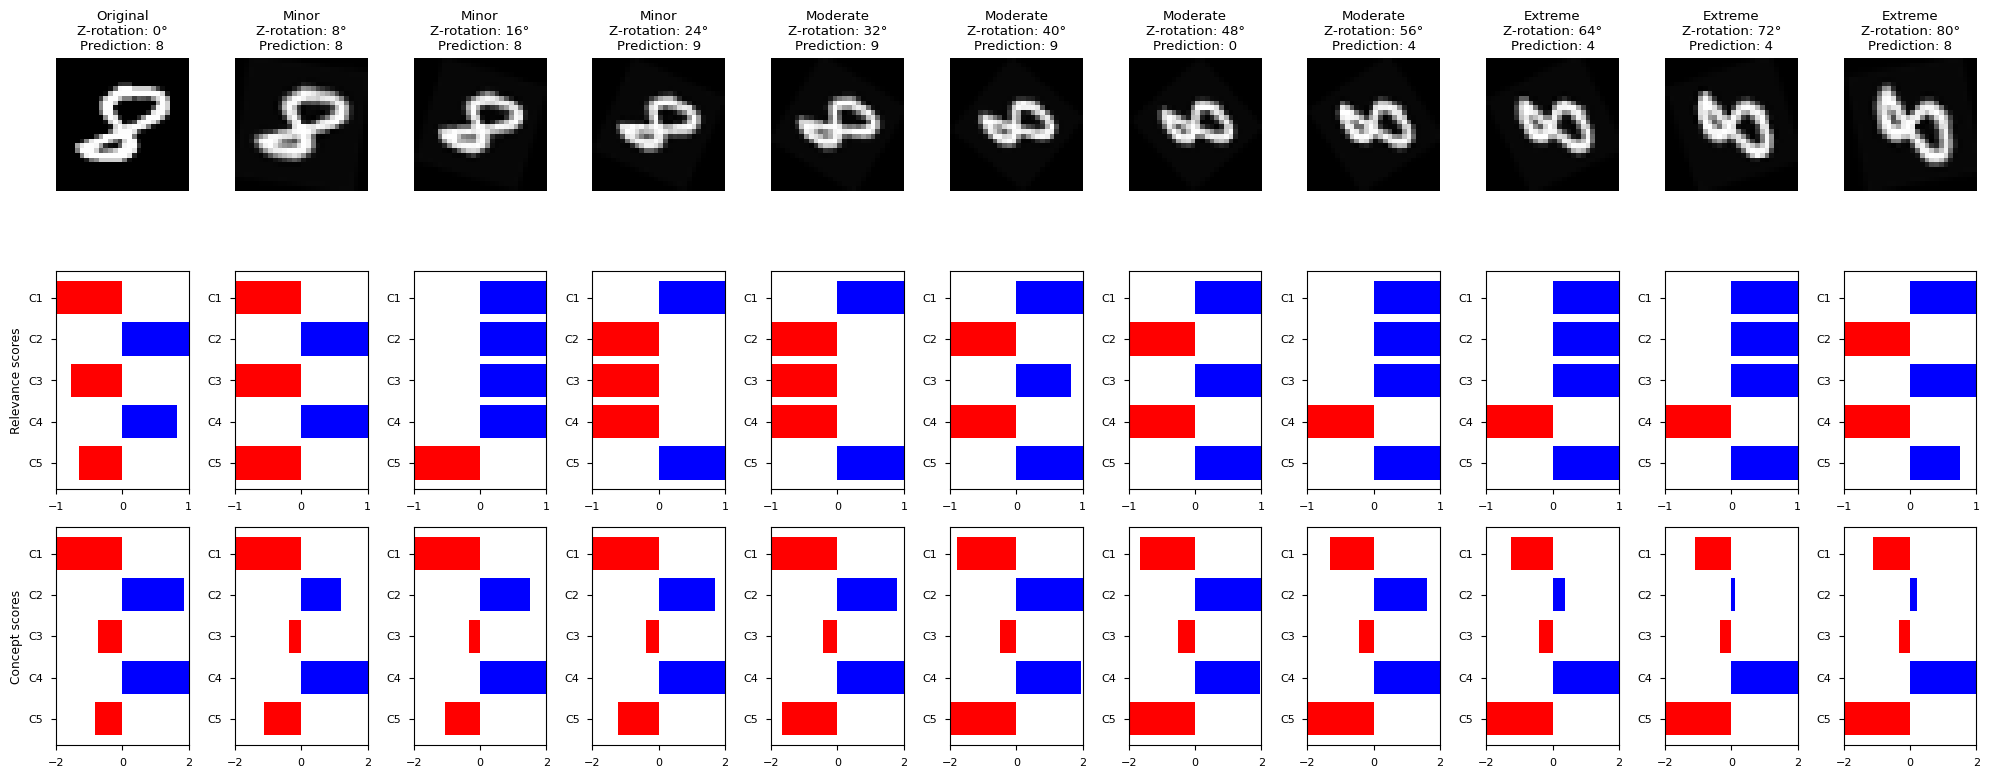


Analyzing digit 9

Analyzing X-axis rotations for digit 9


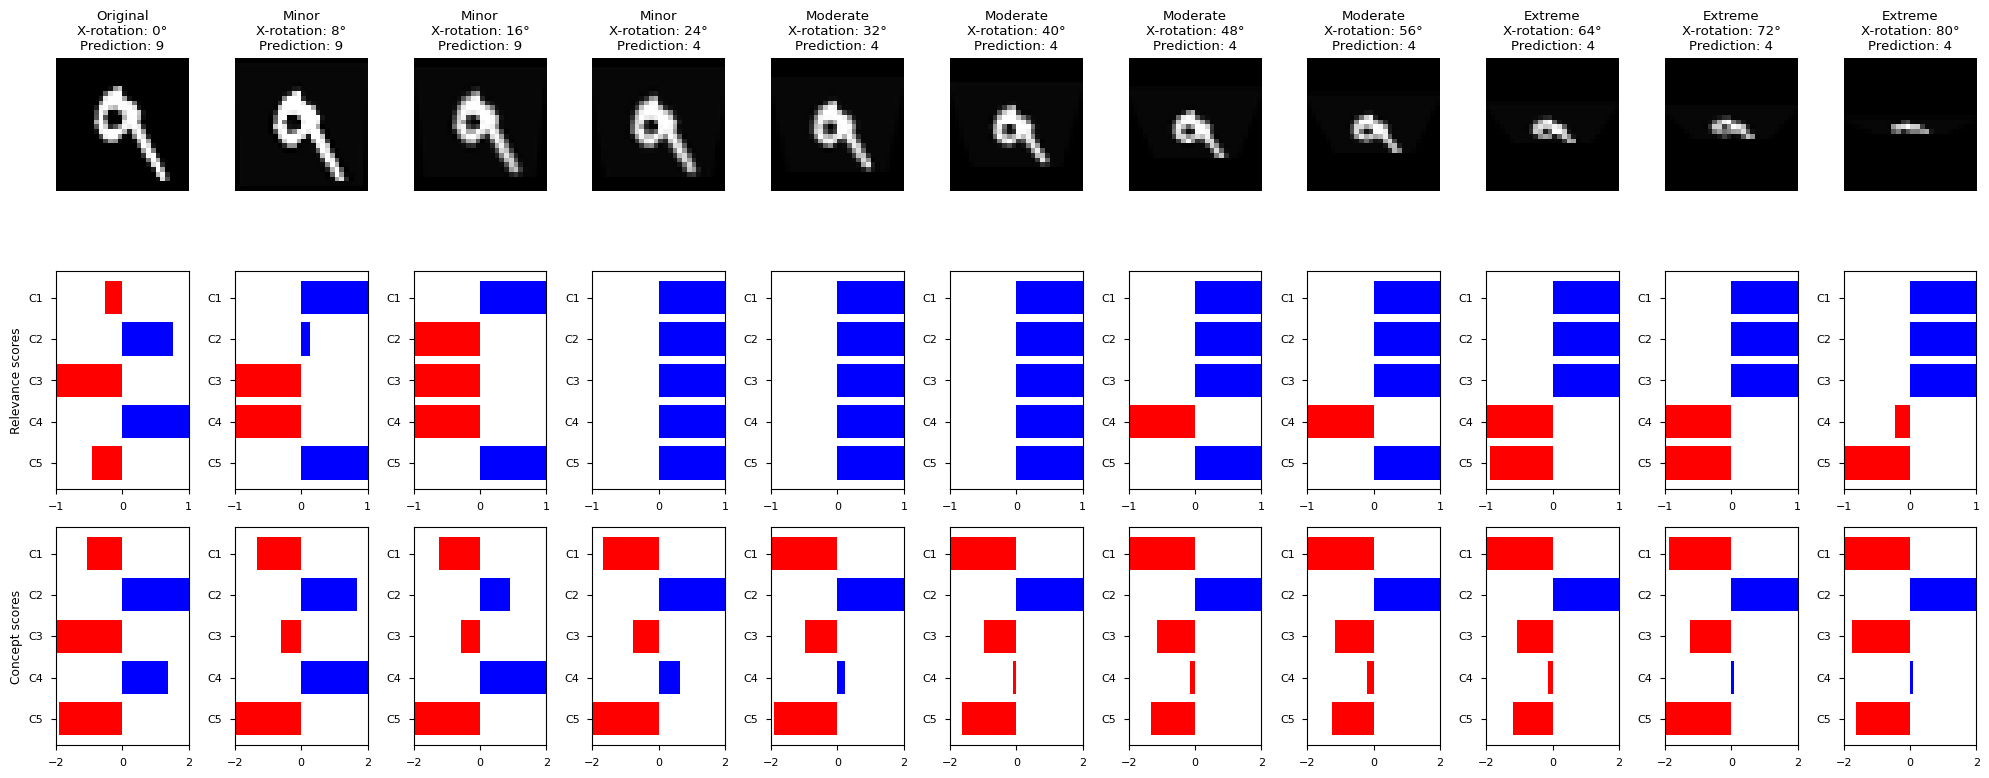


Analyzing Y-axis rotations for digit 9


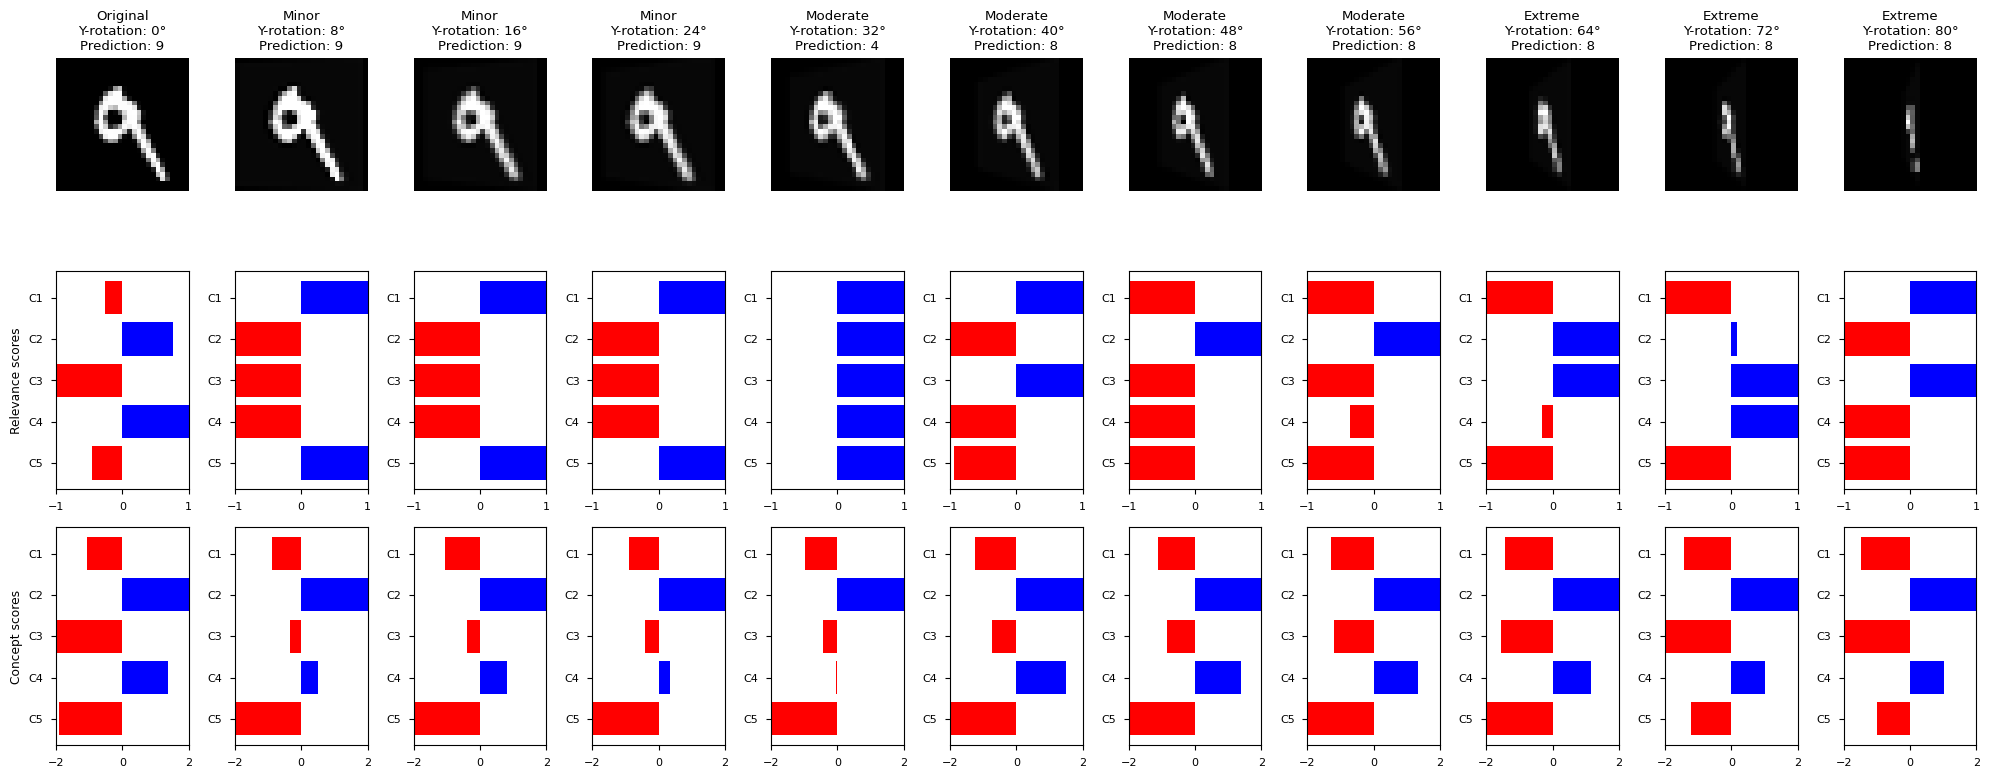


Analyzing Z-axis rotations for digit 9


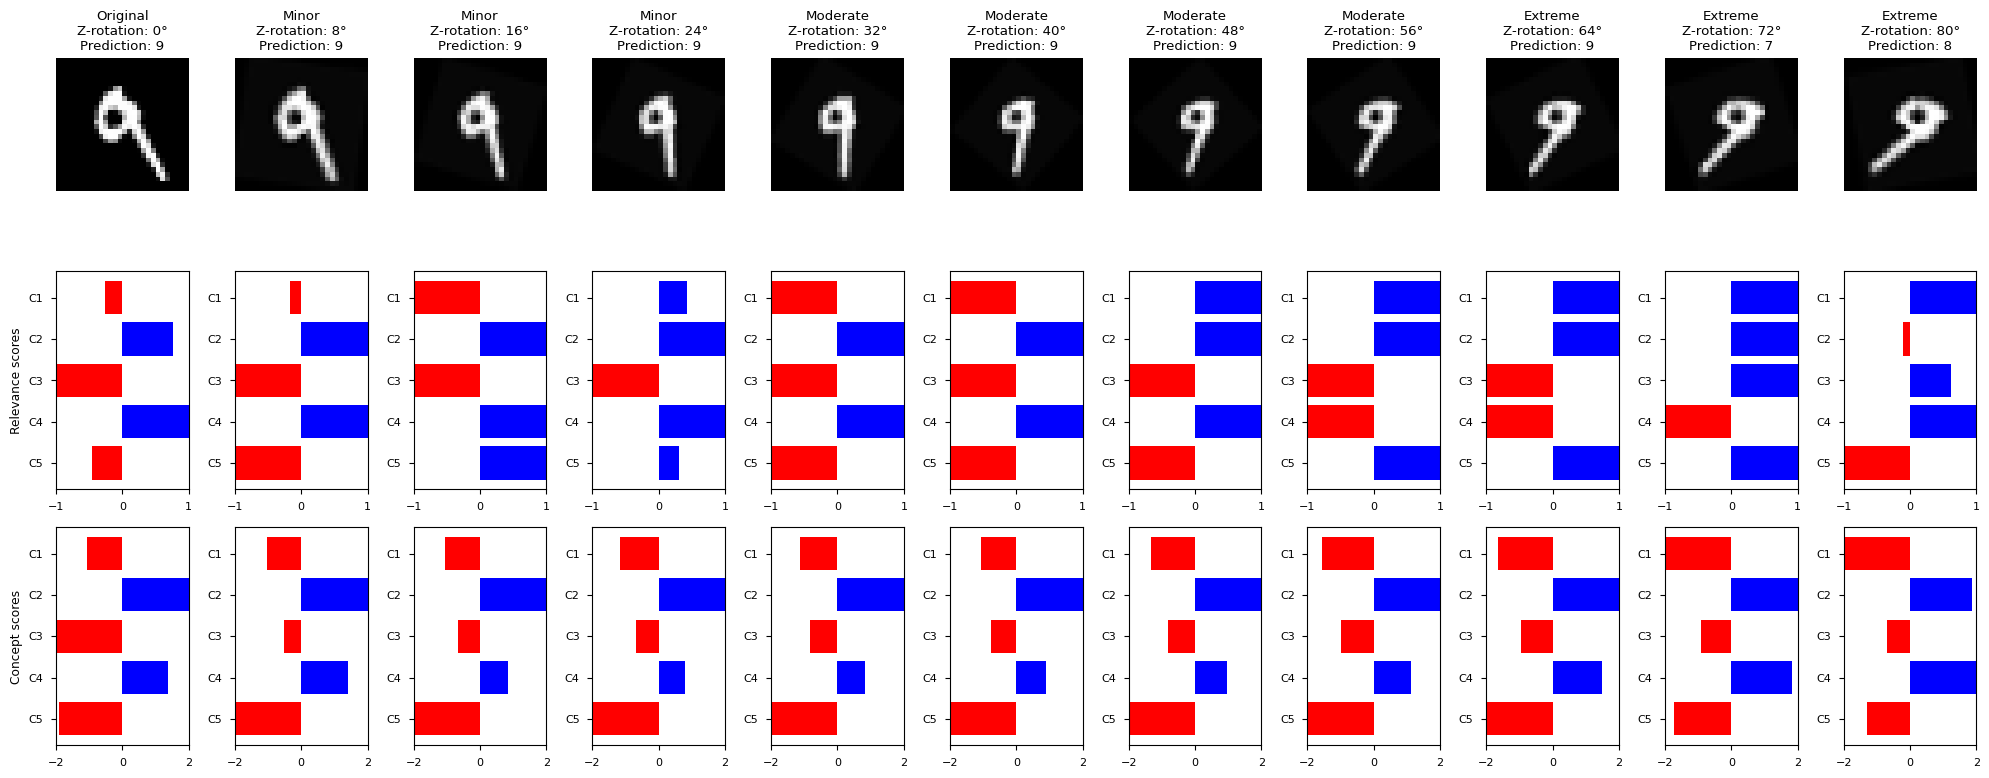

In [19]:
# Get one example of each digit
digit_examples = {}
for batch, labels in mnist_test_dl:
    for img, label in zip(batch, labels):
        label = label.item()
        if label not in digit_examples:
            digit_examples[label] = img
        if len(digit_examples) == 10:
            break
    if len(digit_examples) == 10:
        break

# Analyze each digit
for digit in range(10):
    print(f"\n{'='*50}\nAnalyzing digit {digit}\n{'='*50}")
    sample_image = digit_examples[digit].unsqueeze(0)
    analyze_digit_rotations(mnist_SENN, sample_image, digit)

# 4. Systematic Rotation Analysis

In [23]:
from tqdm import tqdm

def analyze_rotation_accuracy(model, test_dataloader, save_path=None):
    """Analyzes how model accuracy changes with rotation degree across all axes."""
    angles = list(range(0, 82, 2))  # 0 to 80 degrees in steps of 2
    axes = ['x', 'y', 'z']
    device = 'cuda:0' if next(model.parameters()).is_cuda else 'cpu'
    model.eval()
    
    # Initialize results dictionary
    results = {
        axis: {angle: {'correct': 0, 'total': 0} for angle in angles}
        for axis in axes
    }
    
    # Calculate total iterations for progress bar
    total_batches = len(test_dataloader)
    
    # Process all test images
    with torch.no_grad():
        # Add progress bar
        progress_bar = tqdm(test_dataloader, total=total_batches, desc="Processing test images")
        for batch, labels in progress_bar:
            batch = batch.to(device)
            labels = labels.to(device)
            
            # Get original predictions
            for axis in axes:
                for angle in angles:
                    if angle == 0:
                        rotated_batch = batch
                    else:
                        # Rotate each image in the batch
                        rotated_images = []
                        for img in batch:
                            img_np = img.squeeze().cpu().numpy()
                            img_bgr = cv2.merge([img_np] * 3)
                            rotation_args = {f"{axis.lower()}_rotation": angle}
                            _, rotated = rotate_resize_and_cast(img_bgr, **rotation_args)
                            rotated_tensor = torch.tensor(rotated[:,:,0]).unsqueeze(0).float().to(device)
                            rotated_images.append(rotated_tensor)
                        rotated_batch = torch.stack(rotated_images)
                    
                    # Get predictions
                    predictions, _, _ = model(rotated_batch)
                    pred_labels = predictions.argmax(dim=1)
                    
                    # Update results
                    correct = (pred_labels == labels).sum().item()
                    results[axis][angle]['correct'] += correct
                    results[axis][angle]['total'] += len(labels)
    
    # Calculate accuracies and plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for axis in axes:
        accuracies = [
            results[axis][angle]['correct'] / results[axis][angle]['total'] * 100
            for angle in angles
        ]
        ax.plot(angles, accuracies, marker='o', label=f'{axis}-axis rotation')
    
    ax.set_xlabel('Robustness Rotation Angle (degrees)', fontsize=12)  # Updated x-axis label
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Model Accuracy vs. Rotation Angle', fontsize=14)
    ax.grid(True)
    ax.legend()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()
    return results

Processing test images: 100%|██████████| 50/50 [04:15<00:00,  5.10s/it]


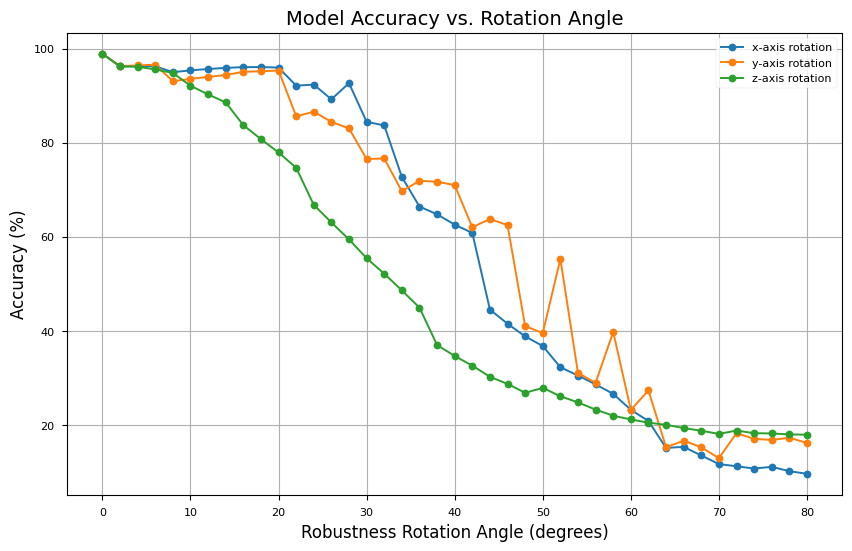

In [24]:
# Usage:
results = analyze_rotation_accuracy(mnist_SENN, mnist_test_dl, save_path='rotation_accuracy.png')